# Comprehensive Wikipedia Bias Analysis: All Plots for All Languages and Attributes

This notebook generates **ALL** visualization plots for the Wikipedia bias analysis:

## Coverage
- **Languages**: English (en), German (de), French (fr), Italian (it), Spanish (es), and Aggregated (all)
- **Attributes**: Gender, Geographic Region (UN Subregion), Birth Period
- **Plot Types**: 
  - Retention Curves (Edge and Node retention)
  - AUC Heatmaps (normalized)

## Total Plots Generated
- **Per Dataset**: 6 languages × 3 attributes × 2 plot types = **36 plots**
- **Two Datasets** (Full + Time-Restricted): **72 total plots**

This creates a comprehensive visual analysis of bias patterns across all dimensions.

## Setup and Imports

In [1]:
import os
import sys
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import logging

# Add project root to Python path
project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))
if project_root not in sys.path:
    sys.path.insert(0, project_root)

print(f"Project root: {project_root}")

# Configure logging
logging.basicConfig(
    level=logging.INFO,
    format='%(levelname)s: %(message)s'
)

# Import analysis modules
from src import analysis, filters

print("✓ Modules imported successfully")

# Set visualization defaults
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')
%matplotlib inline

print("✓ Visualization settings configured")

Project root: /home/vlr/Workspaces/WikipediaBiasProject/PyProject
✓ Modules imported successfully
✓ Visualization settings configured


## Configuration

In [2]:
# Data paths (update EDGE_CSV to your most recent SpotlightWeightSource_MMDD_HHMM.csv)
EDGE_CSV = os.path.join(project_root, "data/out/SpotlightWeightSource_0102_0505.csv")
META_CSV = os.path.join(project_root, "data/entities_filtered_by_languages.csv")
BASE_OUTPUT_DIR = os.path.join(project_root, "data/out/plots")
os.makedirs(BASE_OUTPUT_DIR, exist_ok=True)

# Extract dataset name from edge CSV
DATASET_NAME = os.path.splitext(os.path.basename(EDGE_CSV))[0]

# Analysis parameters
MIN_EDGES = 500  # Minimum edges for statistical reliability
RESOLUTION = 50  # Threshold points (higher = more precise but slower)
LOGSPACE_LOWER_BOUND = -14  # Lower bound for logspace threshold calculation

# ALL Languages - comprehensive analysis
SELECTED_LANGUAGES = ['en', 'de', 'fr', 'it', 'es']
ALL_LANGUAGES_WITH_AGG = SELECTED_LANGUAGES + ['all']  # Include aggregated

# ALL Attributes
ATTRIBUTES = ['gender', 'un_subregion', 'bigperiod_birth']

# Time restriction for comparison analysis
MIN_YEAR = 1750
MAX_YEAR = 1950

print(f"Dataset: {DATASET_NAME}")
print(f"Languages to analyze: {', '.join(ALL_LANGUAGES_WITH_AGG)}")
print(f"Attributes to analyze: {', '.join(ATTRIBUTES)}")
print(f"Minimum edges threshold: {MIN_EDGES}")
print(f"Resolution: {RESOLUTION} points")
print(f"\nTotal plots per dataset: {len(ALL_LANGUAGES_WITH_AGG)} languages × {len(ATTRIBUTES)} attributes × 2 plot types = {len(ALL_LANGUAGES_WITH_AGG) * len(ATTRIBUTES) * 2}")

Dataset: SpotlightWeightSource_0102_0505
Languages to analyze: en, de, fr, it, es, all
Attributes to analyze: gender, un_subregion, bigperiod_birth
Minimum edges threshold: 500
Resolution: 50 points

Total plots per dataset: 6 languages × 3 attributes × 2 plot types = 36


## Load Data

In [3]:
print("Loading data...")
edges_df = pd.read_csv(EDGE_CSV)
meta_df = pd.read_csv(META_CSV)

print(f"✓ Loaded {len(edges_df):,} edges")
print(f"✓ Loaded {len(meta_df):,} metadata records")
print(f"\nEdge columns: {list(edges_df.columns)}")
print(f"Meta columns: {list(meta_df.columns)}")

Loading data...
✓ Loaded 12,444,180 edges
✓ Loaded 94,403 metadata records

Edge columns: ['language_code', 'source_wikidata_id', 'target_wikidata_id', 'weight']
Meta columns: ['wikidata_id', 'birth', 'bigperiod_birth', 'un_subregion', 'gender']


---
# Part 1: Full Dataset Analysis

Analyzing all available data without time restrictions.

## Run Full Dataset Analysis

In [4]:
print("="*80)
print("RUNNING FULL DATASET ANALYSIS")
print("="*80)

# Build output directories
OUTPUT_DIRS_FULL = analysis.build_analysis_output_dirs(
    base_output_dir=BASE_OUTPUT_DIR,
    dataset_name=DATASET_NAME,
    filter_description="full",
    resolution=RESOLUTION,
    min_edges=MIN_EDGES,
    selected_languages=SELECTED_LANGUAGES,
    attributes=ATTRIBUTES,
    logspace_lower_bound=LOGSPACE_LOWER_BOUND
)

print(f"Output directory: {OUTPUT_DIRS_FULL['base']}")

# Try to load cached results first
print("\nChecking for cached results...")
retention_full = analysis.load_cached_analysis_results(
    OUTPUT_DIRS_FULL,
    ALL_LANGUAGES_WITH_AGG,
    ATTRIBUTES
)

if retention_full is not None:
    print("✓ Loaded cached results")
else:
    print("Cache not found. Running fresh analysis...")
    
    # Run analysis
    retention_full = analysis.run_bias_analysis(
        edges_df=edges_df,
        meta_df=meta_df,
        edge_id_map={
            'source_wikidata_id': 'src',
            'target_wikidata_id': 'trg',
            'weight': 'nij'
        },
        meta_id_col='wikidata_id',
        selected_languages=SELECTED_LANGUAGES,
        min_edges=MIN_EDGES,
        resolution=RESOLUTION,
        filter_zero_weights=True,
        language_col='language_code',
        add_aggregated_all=True,
        pre_transform_filters=None,
        post_transform_filters=None,
        dataset_label='full'
    )
    
    # Save results
    print("\nSaving results...")
    analysis.save_analysis_results(
        retention_full, 
        OUTPUT_DIRS_FULL, 
        ALL_LANGUAGES_WITH_AGG, 
        ATTRIBUTES,
        resolution=RESOLUTION,
        min_edges=MIN_EDGES,
        logspace_lower_bound=LOGSPACE_LOWER_BOUND,
        dataset_name=DATASET_NAME,
        filter_description="full"
    )
    print("✓ Results saved")

print("\n✓ Full dataset analysis complete")

INFO: Found cached results. Loading...
INFO: Cached results loaded successfully


RUNNING FULL DATASET ANALYSIS
Output directory: /home/vlr/Workspaces/WikipediaBiasProject/PyProject/data/out/plots/SpotlightWeightSource_0102_0505_full_res50_min500_langs5_attrs3

Checking for cached results...
✓ Loaded cached results

✓ Full dataset analysis complete


## Generate ALL Plots for Full Dataset

This will generate:
- Retention curves (edge + node) for each language-attribute combination
- AUC heatmaps for each language-attribute combination

GENERATING ALL PLOTS FOR FULL DATASET
Total plots to generate: 36


Language: EN

  Attribute: gender
  ----------------------------------------------------------------------------
  📊 Plotting retention curves for en - gender...


INFO: Saved plot: /home/vlr/Workspaces/WikipediaBiasProject/PyProject/data/out/plots/SpotlightWeightSource_0102_0505_full_res50_min500_langs5_attrs3/retention_curves_full_res50_min500_langs5_attrs3/retention_curves_en_gender.png


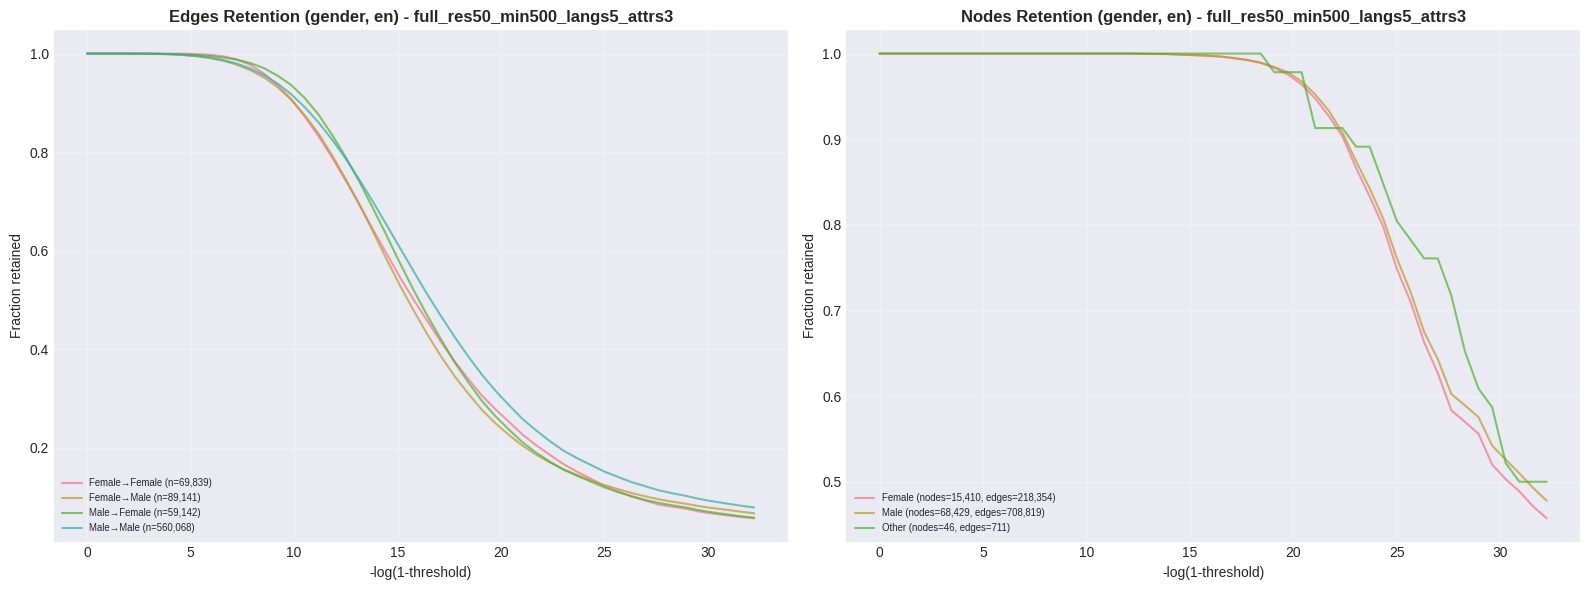

INFO: Saved plot: /home/vlr/Workspaces/WikipediaBiasProject/PyProject/data/out/plots/SpotlightWeightSource_0102_0505_full_res50_min500_langs5_attrs3/heatmaps_full_res50_min500_langs5_attrs3/heatmap_en_gender.png


  🔥 Plotting AUC heatmap for en - gender...


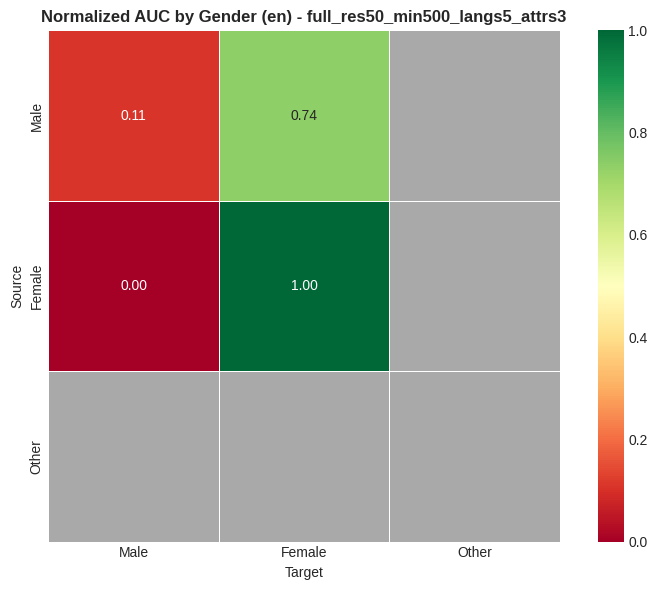


  Attribute: un_subregion
  ----------------------------------------------------------------------------
  📊 Plotting retention curves for en - un_subregion...


INFO: Saved plot: /home/vlr/Workspaces/WikipediaBiasProject/PyProject/data/out/plots/SpotlightWeightSource_0102_0505_full_res50_min500_langs5_attrs3/retention_curves_full_res50_min500_langs5_attrs3/retention_curves_en_un_subregion.png


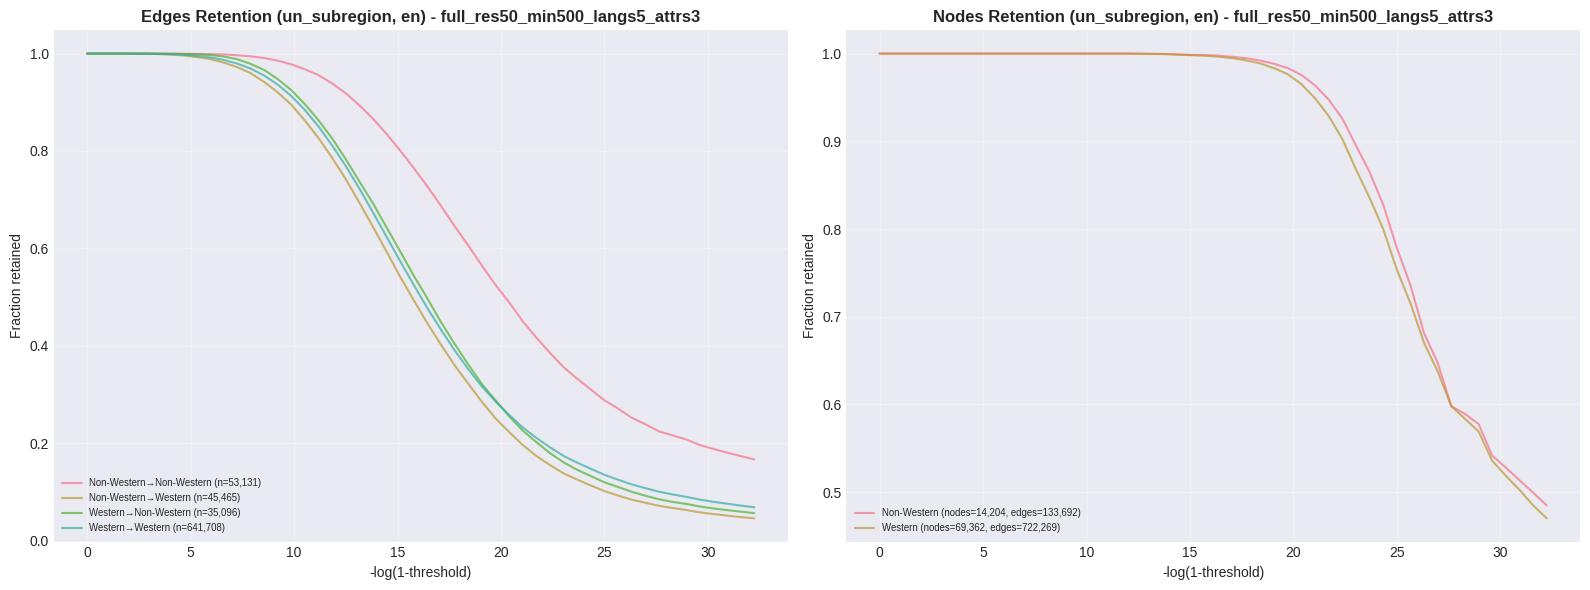

INFO: Saved plot: /home/vlr/Workspaces/WikipediaBiasProject/PyProject/data/out/plots/SpotlightWeightSource_0102_0505_full_res50_min500_langs5_attrs3/heatmaps_full_res50_min500_langs5_attrs3/heatmap_en_un_subregion.png


  🔥 Plotting AUC heatmap for en - un_subregion...


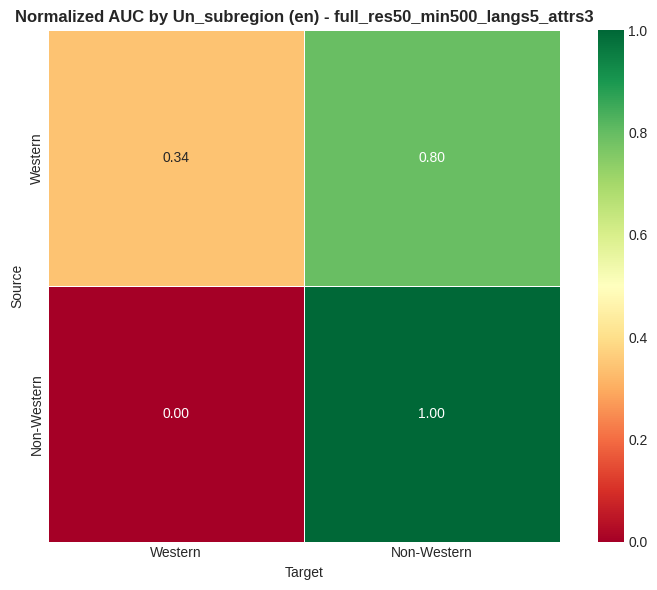


  Attribute: bigperiod_birth
  ----------------------------------------------------------------------------
  📊 Plotting retention curves for en - bigperiod_birth...


INFO: Saved plot: /home/vlr/Workspaces/WikipediaBiasProject/PyProject/data/out/plots/SpotlightWeightSource_0102_0505_full_res50_min500_langs5_attrs3/retention_curves_full_res50_min500_langs5_attrs3/retention_curves_en_bigperiod_birth.png


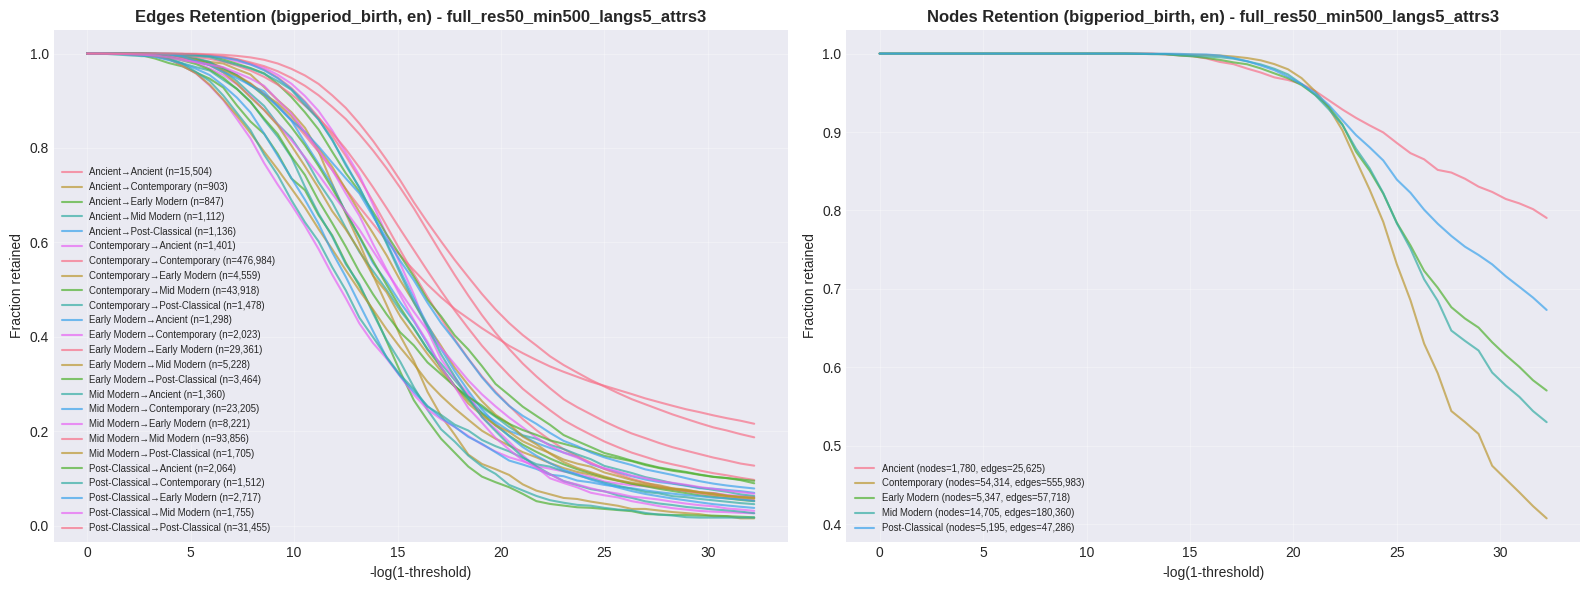

INFO: Saved plot: /home/vlr/Workspaces/WikipediaBiasProject/PyProject/data/out/plots/SpotlightWeightSource_0102_0505_full_res50_min500_langs5_attrs3/heatmaps_full_res50_min500_langs5_attrs3/heatmap_en_bigperiod_birth.png


  🔥 Plotting AUC heatmap for en - bigperiod_birth...


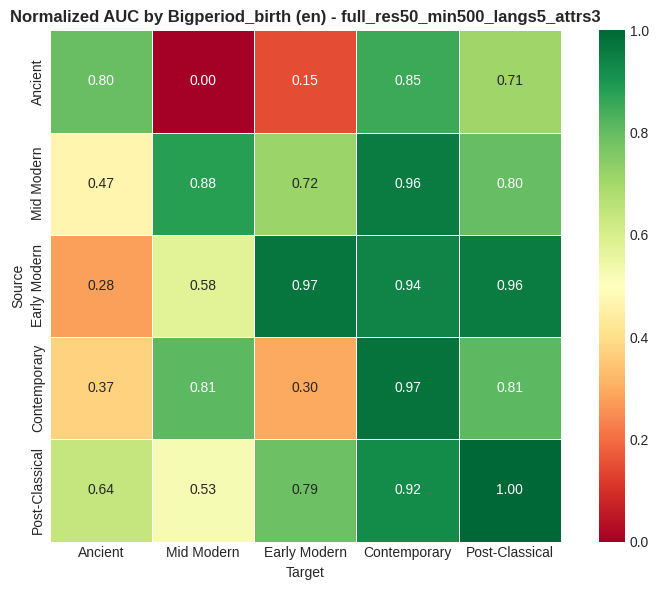


Language: DE

  Attribute: gender
  ----------------------------------------------------------------------------
  📊 Plotting retention curves for de - gender...


INFO: Saved plot: /home/vlr/Workspaces/WikipediaBiasProject/PyProject/data/out/plots/SpotlightWeightSource_0102_0505_full_res50_min500_langs5_attrs3/retention_curves_full_res50_min500_langs5_attrs3/retention_curves_de_gender.png


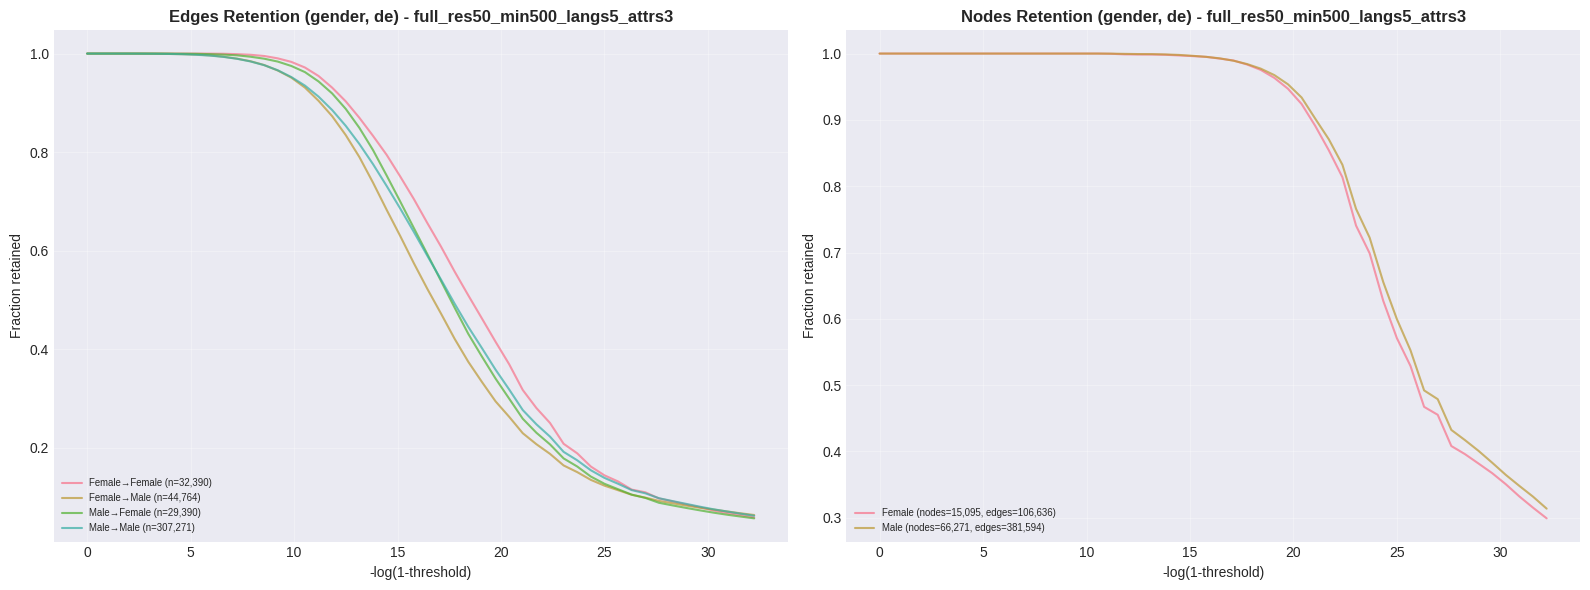

INFO: Saved plot: /home/vlr/Workspaces/WikipediaBiasProject/PyProject/data/out/plots/SpotlightWeightSource_0102_0505_full_res50_min500_langs5_attrs3/heatmaps_full_res50_min500_langs5_attrs3/heatmap_de_gender.png


  🔥 Plotting AUC heatmap for de - gender...


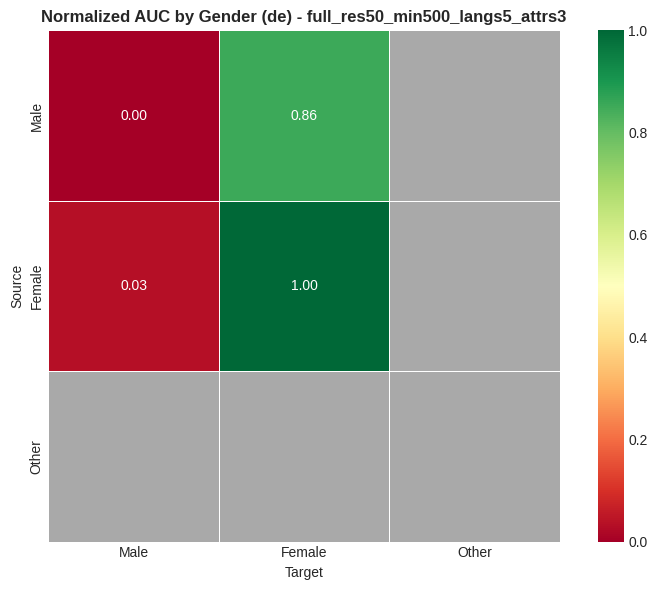


  Attribute: un_subregion
  ----------------------------------------------------------------------------
  📊 Plotting retention curves for de - un_subregion...


INFO: Saved plot: /home/vlr/Workspaces/WikipediaBiasProject/PyProject/data/out/plots/SpotlightWeightSource_0102_0505_full_res50_min500_langs5_attrs3/retention_curves_full_res50_min500_langs5_attrs3/retention_curves_de_un_subregion.png


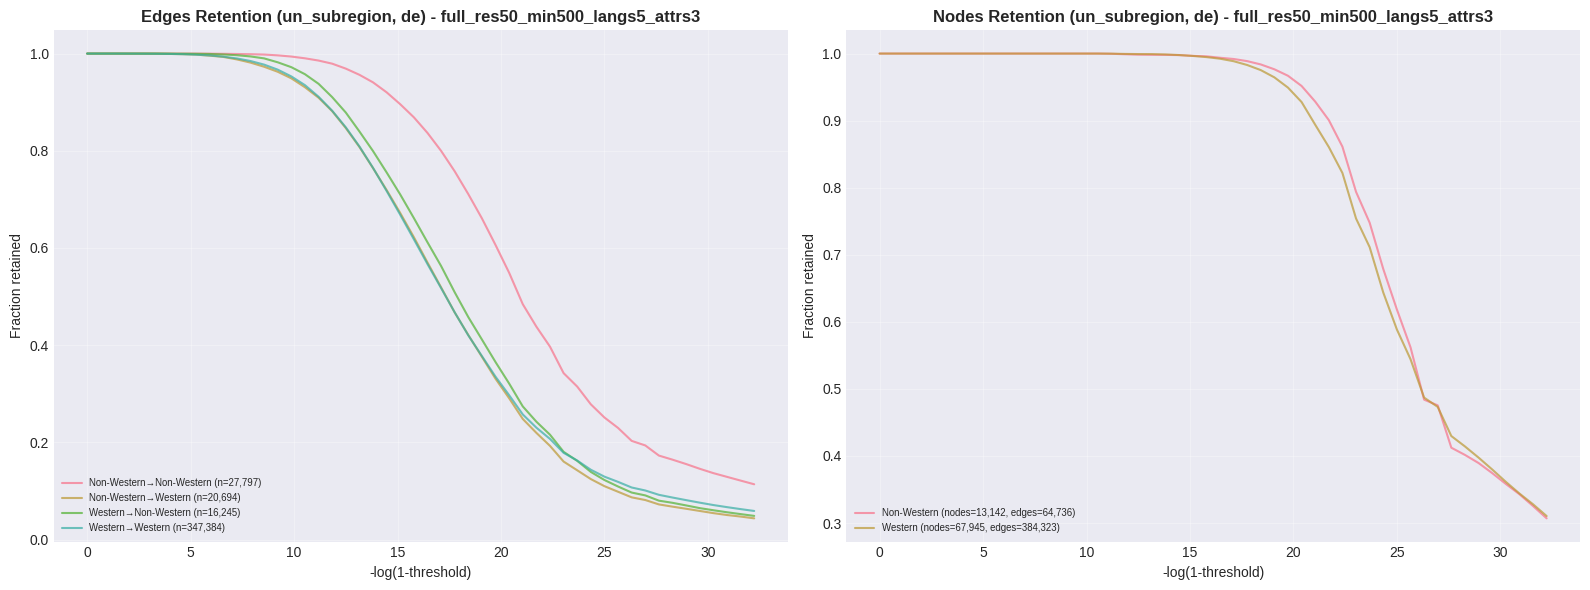

INFO: Saved plot: /home/vlr/Workspaces/WikipediaBiasProject/PyProject/data/out/plots/SpotlightWeightSource_0102_0505_full_res50_min500_langs5_attrs3/heatmaps_full_res50_min500_langs5_attrs3/heatmap_de_un_subregion.png


  🔥 Plotting AUC heatmap for de - un_subregion...


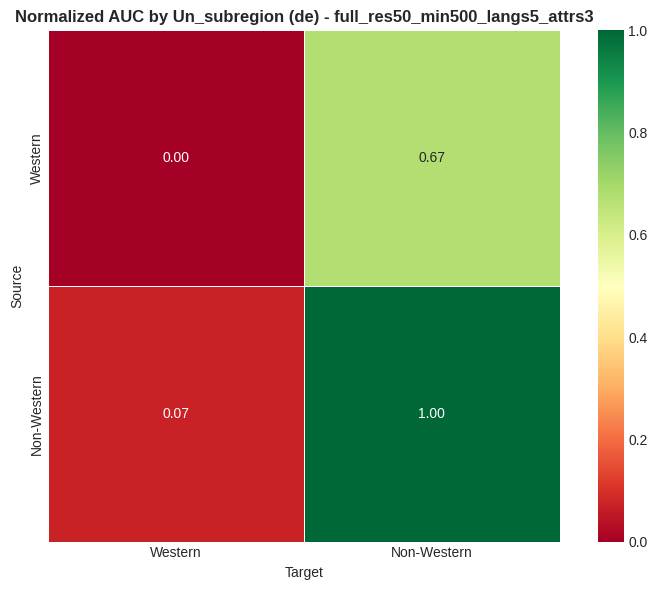


  Attribute: bigperiod_birth
  ----------------------------------------------------------------------------
  📊 Plotting retention curves for de - bigperiod_birth...


INFO: Saved plot: /home/vlr/Workspaces/WikipediaBiasProject/PyProject/data/out/plots/SpotlightWeightSource_0102_0505_full_res50_min500_langs5_attrs3/retention_curves_full_res50_min500_langs5_attrs3/retention_curves_de_bigperiod_birth.png


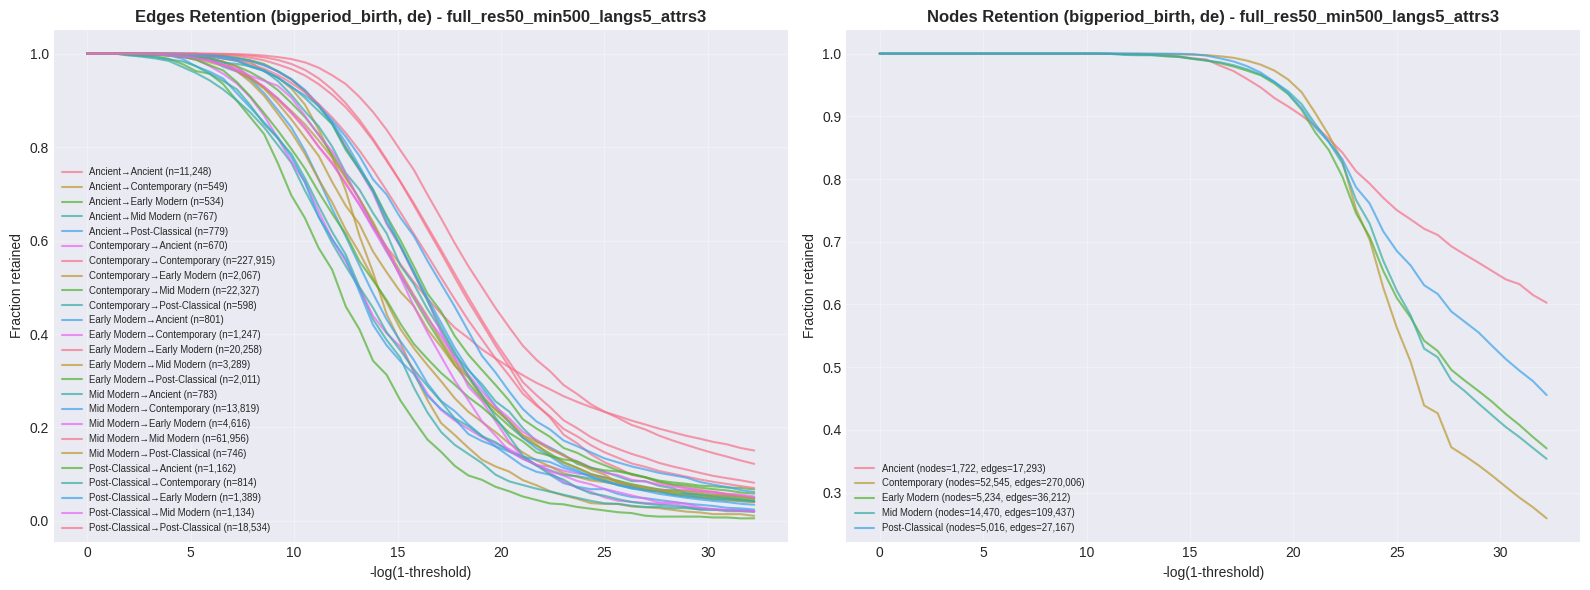

INFO: Saved plot: /home/vlr/Workspaces/WikipediaBiasProject/PyProject/data/out/plots/SpotlightWeightSource_0102_0505_full_res50_min500_langs5_attrs3/heatmaps_full_res50_min500_langs5_attrs3/heatmap_de_bigperiod_birth.png


  🔥 Plotting AUC heatmap for de - bigperiod_birth...


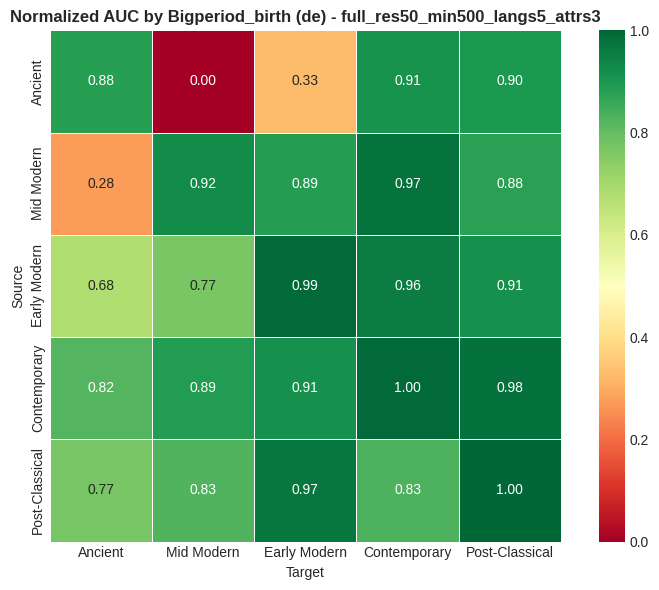


Language: FR

  Attribute: gender
  ----------------------------------------------------------------------------
  📊 Plotting retention curves for fr - gender...


INFO: Saved plot: /home/vlr/Workspaces/WikipediaBiasProject/PyProject/data/out/plots/SpotlightWeightSource_0102_0505_full_res50_min500_langs5_attrs3/retention_curves_full_res50_min500_langs5_attrs3/retention_curves_fr_gender.png


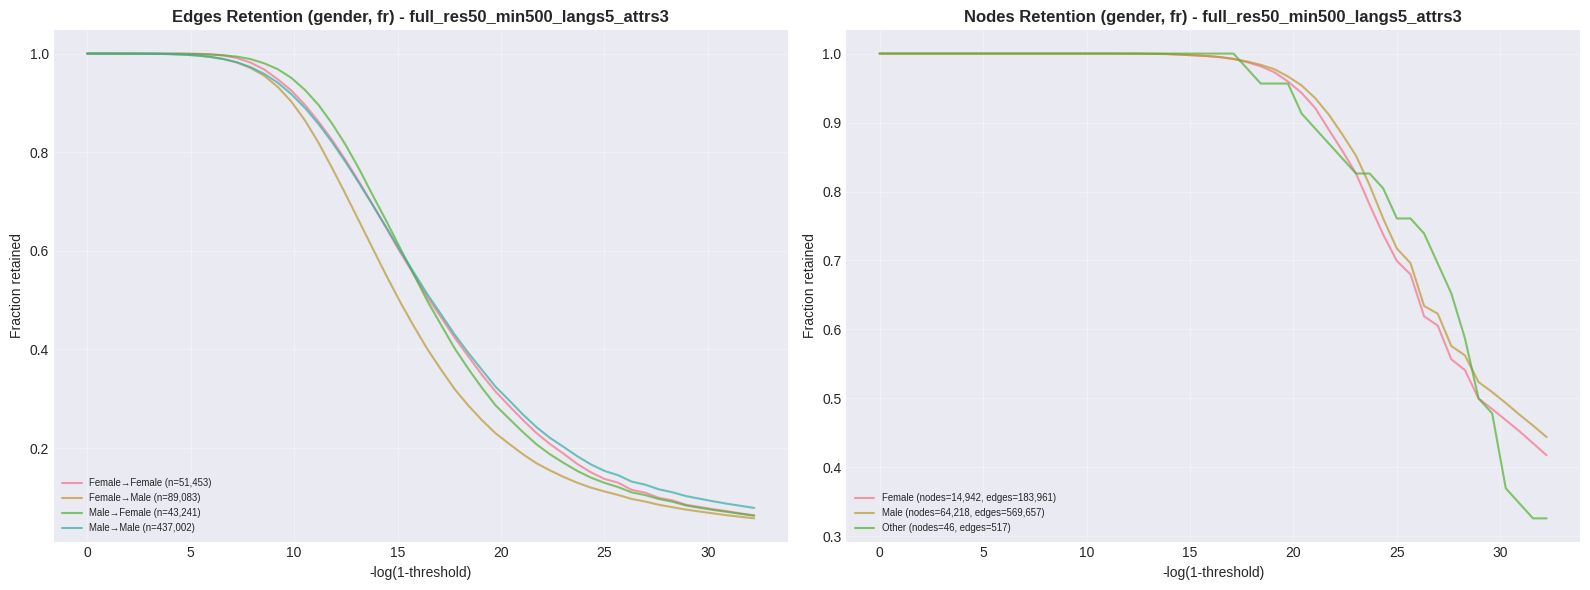

INFO: Saved plot: /home/vlr/Workspaces/WikipediaBiasProject/PyProject/data/out/plots/SpotlightWeightSource_0102_0505_full_res50_min500_langs5_attrs3/heatmaps_full_res50_min500_langs5_attrs3/heatmap_fr_gender.png


  🔥 Plotting AUC heatmap for fr - gender...


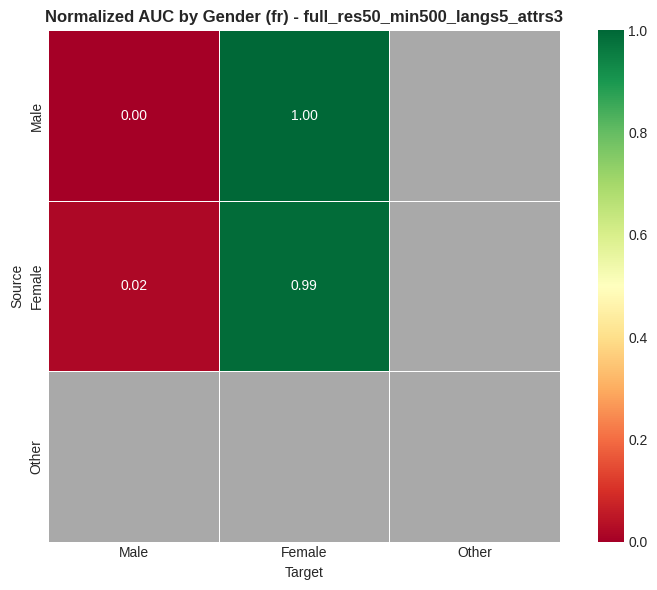


  Attribute: un_subregion
  ----------------------------------------------------------------------------
  📊 Plotting retention curves for fr - un_subregion...


INFO: Saved plot: /home/vlr/Workspaces/WikipediaBiasProject/PyProject/data/out/plots/SpotlightWeightSource_0102_0505_full_res50_min500_langs5_attrs3/retention_curves_full_res50_min500_langs5_attrs3/retention_curves_fr_un_subregion.png


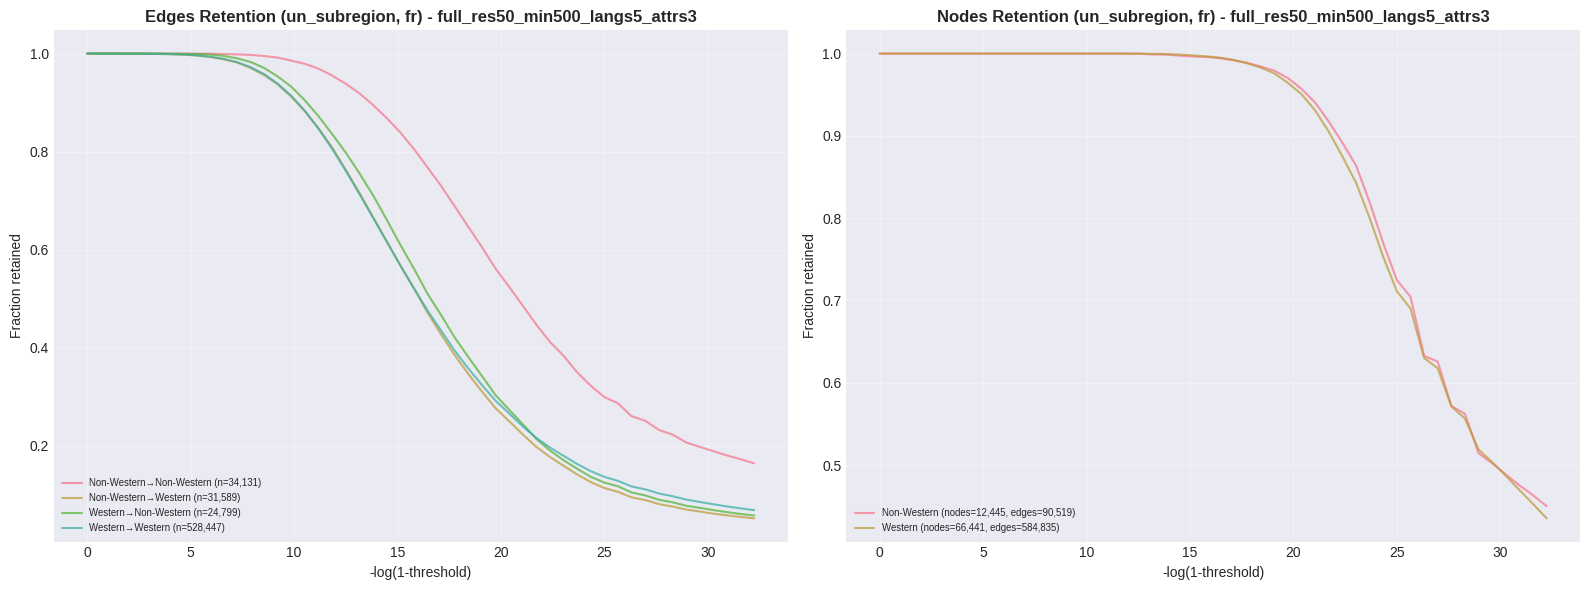

INFO: Saved plot: /home/vlr/Workspaces/WikipediaBiasProject/PyProject/data/out/plots/SpotlightWeightSource_0102_0505_full_res50_min500_langs5_attrs3/heatmaps_full_res50_min500_langs5_attrs3/heatmap_fr_un_subregion.png


  🔥 Plotting AUC heatmap for fr - un_subregion...


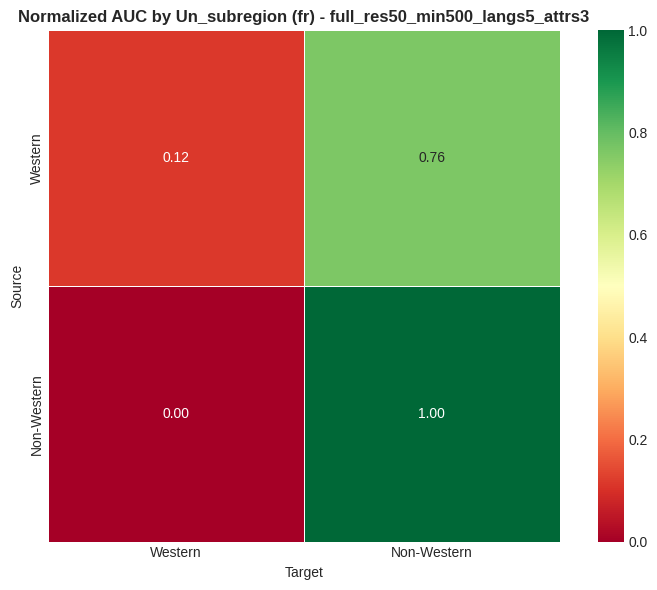


  Attribute: bigperiod_birth
  ----------------------------------------------------------------------------
  📊 Plotting retention curves for fr - bigperiod_birth...


INFO: Saved plot: /home/vlr/Workspaces/WikipediaBiasProject/PyProject/data/out/plots/SpotlightWeightSource_0102_0505_full_res50_min500_langs5_attrs3/retention_curves_full_res50_min500_langs5_attrs3/retention_curves_fr_bigperiod_birth.png


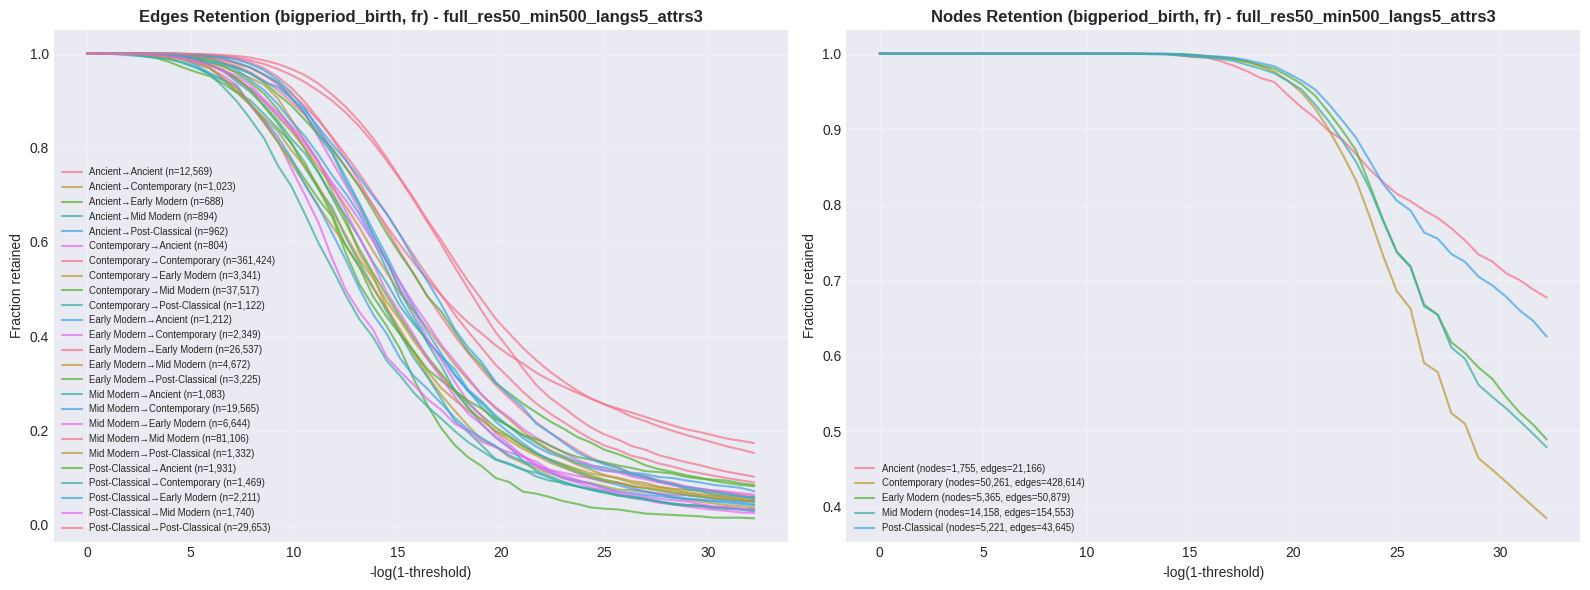

  🔥 Plotting AUC heatmap for fr - bigperiod_birth...


INFO: Saved plot: /home/vlr/Workspaces/WikipediaBiasProject/PyProject/data/out/plots/SpotlightWeightSource_0102_0505_full_res50_min500_langs5_attrs3/heatmaps_full_res50_min500_langs5_attrs3/heatmap_fr_bigperiod_birth.png


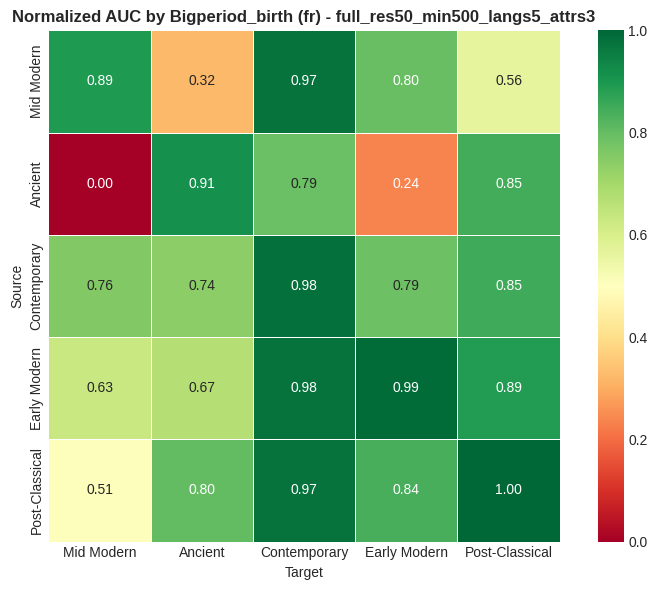


Language: IT

  Attribute: gender
  ----------------------------------------------------------------------------
  📊 Plotting retention curves for it - gender...


INFO: Saved plot: /home/vlr/Workspaces/WikipediaBiasProject/PyProject/data/out/plots/SpotlightWeightSource_0102_0505_full_res50_min500_langs5_attrs3/retention_curves_full_res50_min500_langs5_attrs3/retention_curves_it_gender.png


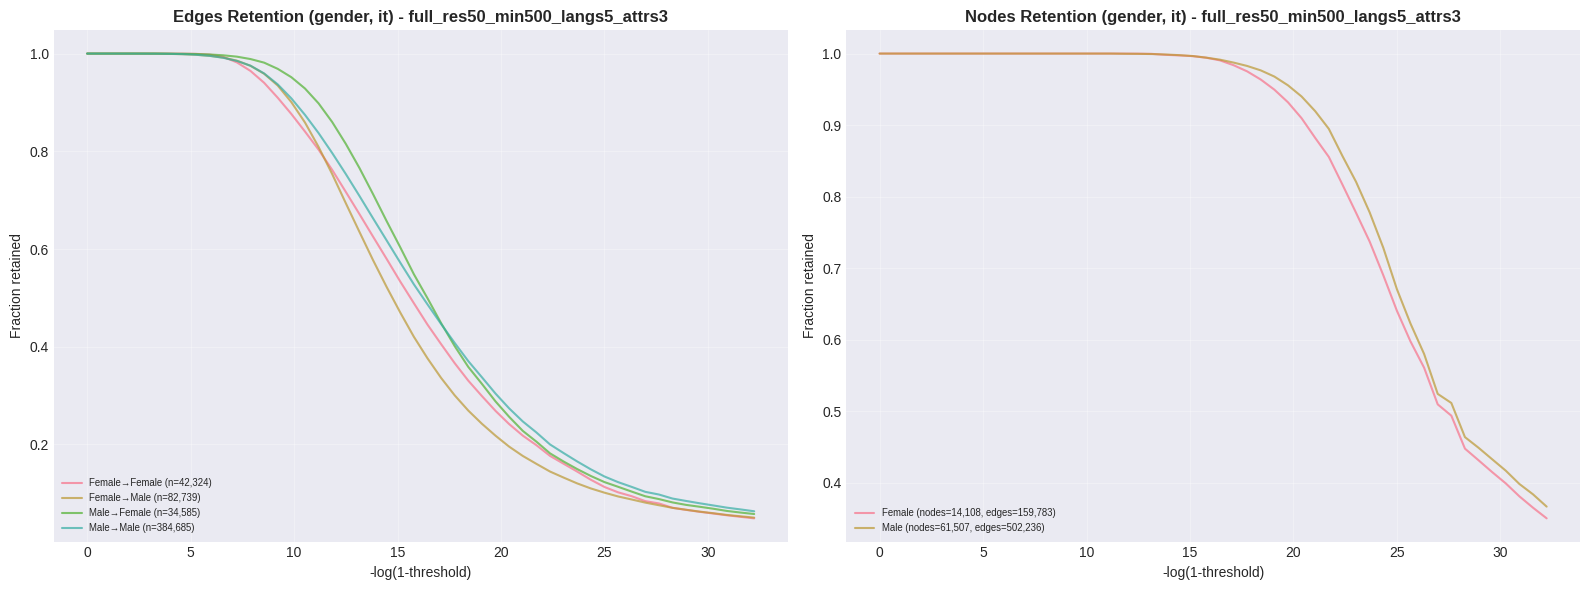

INFO: Saved plot: /home/vlr/Workspaces/WikipediaBiasProject/PyProject/data/out/plots/SpotlightWeightSource_0102_0505_full_res50_min500_langs5_attrs3/heatmaps_full_res50_min500_langs5_attrs3/heatmap_it_gender.png


  🔥 Plotting AUC heatmap for it - gender...


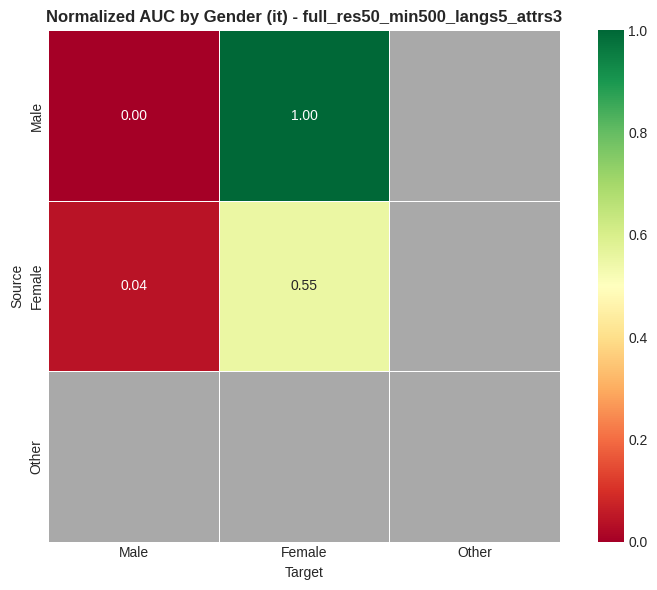


  Attribute: un_subregion
  ----------------------------------------------------------------------------
  📊 Plotting retention curves for it - un_subregion...


INFO: Saved plot: /home/vlr/Workspaces/WikipediaBiasProject/PyProject/data/out/plots/SpotlightWeightSource_0102_0505_full_res50_min500_langs5_attrs3/retention_curves_full_res50_min500_langs5_attrs3/retention_curves_it_un_subregion.png


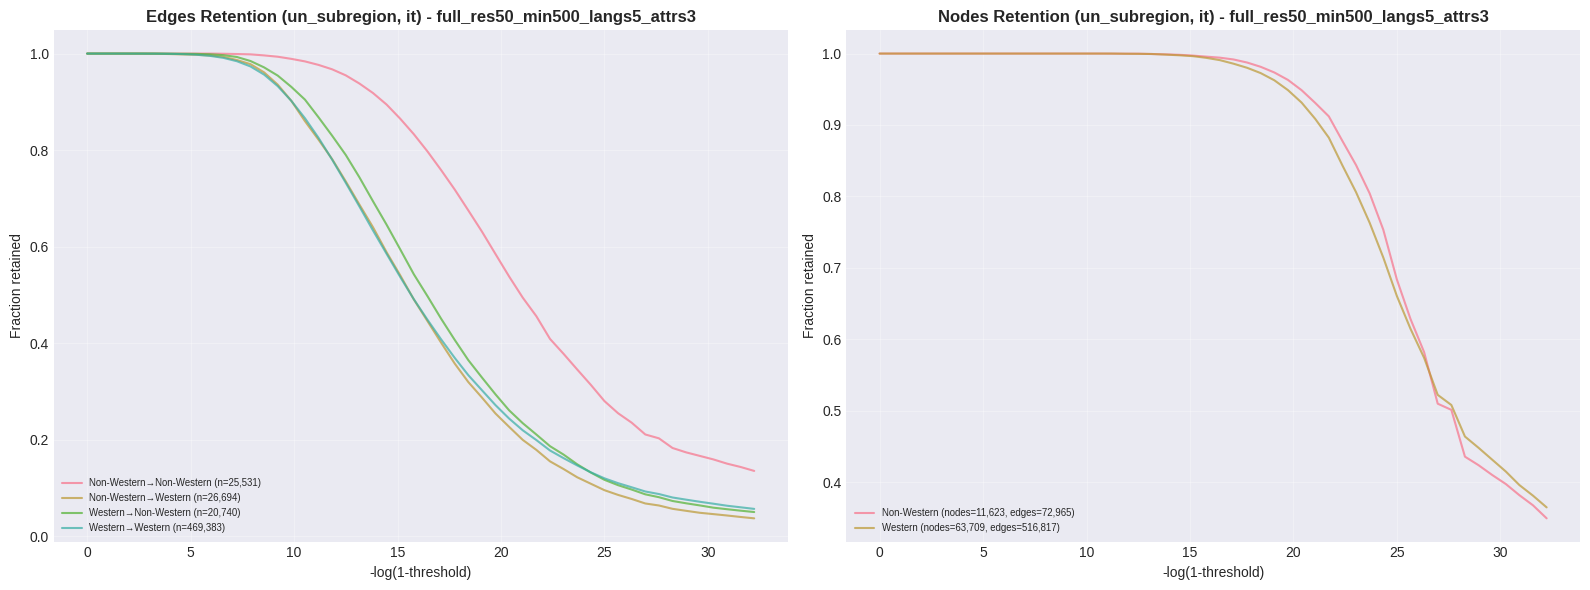

INFO: Saved plot: /home/vlr/Workspaces/WikipediaBiasProject/PyProject/data/out/plots/SpotlightWeightSource_0102_0505_full_res50_min500_langs5_attrs3/heatmaps_full_res50_min500_langs5_attrs3/heatmap_it_un_subregion.png


  🔥 Plotting AUC heatmap for it - un_subregion...


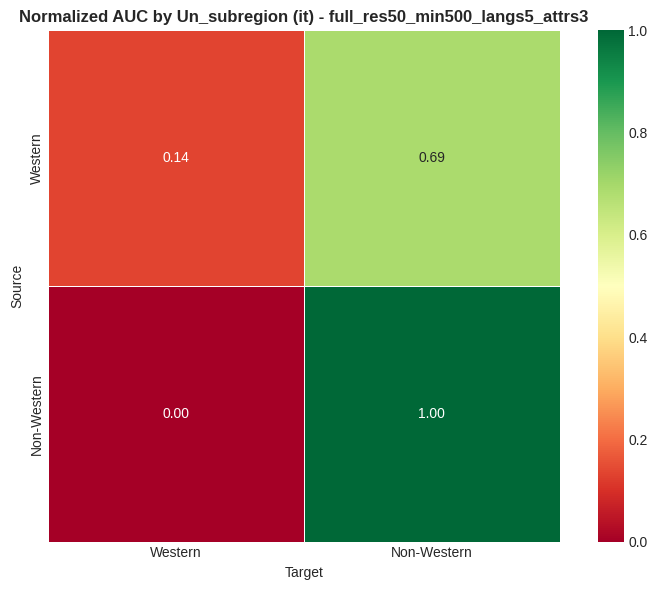


  Attribute: bigperiod_birth
  ----------------------------------------------------------------------------
  📊 Plotting retention curves for it - bigperiod_birth...


INFO: Saved plot: /home/vlr/Workspaces/WikipediaBiasProject/PyProject/data/out/plots/SpotlightWeightSource_0102_0505_full_res50_min500_langs5_attrs3/retention_curves_full_res50_min500_langs5_attrs3/retention_curves_it_bigperiod_birth.png


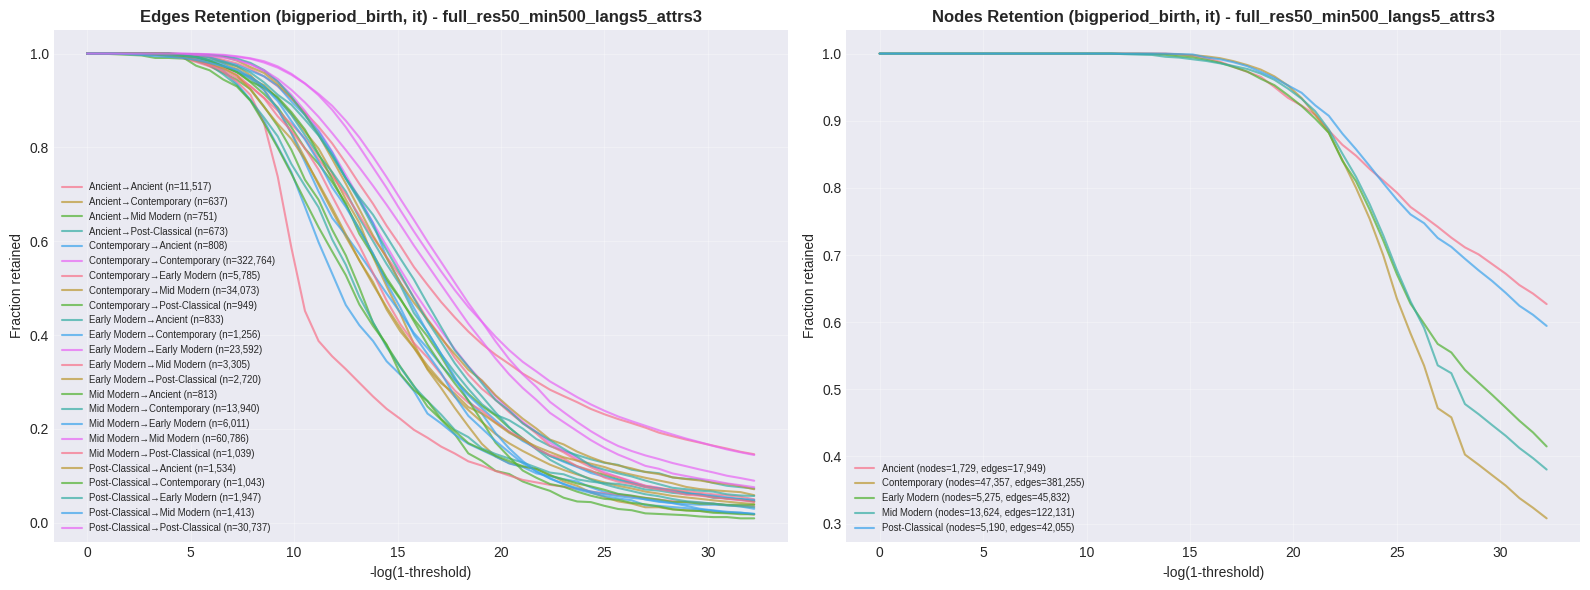

INFO: Saved plot: /home/vlr/Workspaces/WikipediaBiasProject/PyProject/data/out/plots/SpotlightWeightSource_0102_0505_full_res50_min500_langs5_attrs3/heatmaps_full_res50_min500_langs5_attrs3/heatmap_it_bigperiod_birth.png


  🔥 Plotting AUC heatmap for it - bigperiod_birth...


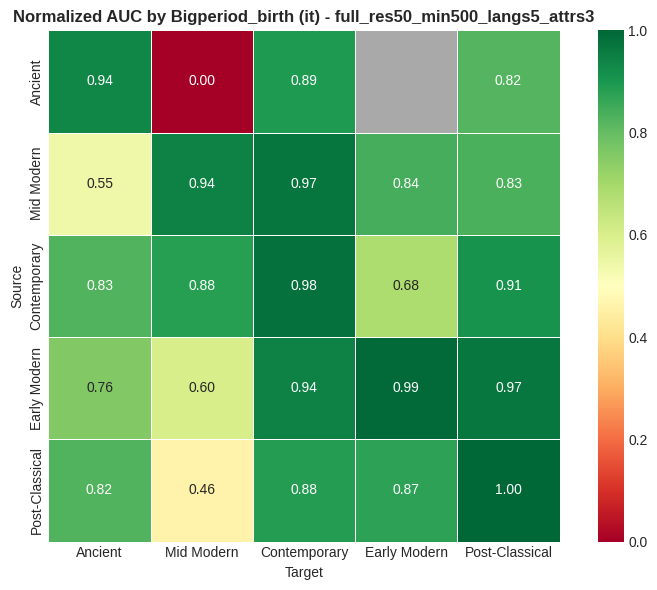


Language: ES

  Attribute: gender
  ----------------------------------------------------------------------------
  📊 Plotting retention curves for es - gender...


INFO: Saved plot: /home/vlr/Workspaces/WikipediaBiasProject/PyProject/data/out/plots/SpotlightWeightSource_0102_0505_full_res50_min500_langs5_attrs3/retention_curves_full_res50_min500_langs5_attrs3/retention_curves_es_gender.png


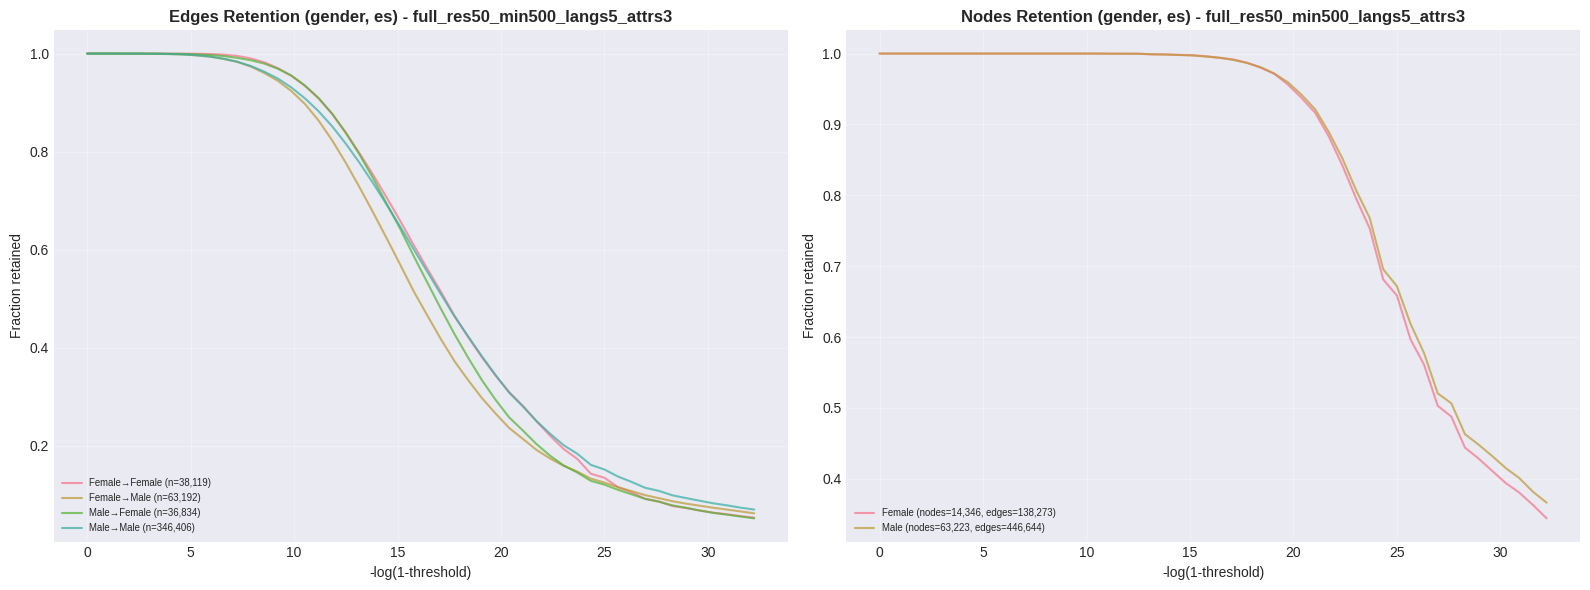

INFO: Saved plot: /home/vlr/Workspaces/WikipediaBiasProject/PyProject/data/out/plots/SpotlightWeightSource_0102_0505_full_res50_min500_langs5_attrs3/heatmaps_full_res50_min500_langs5_attrs3/heatmap_es_gender.png


  🔥 Plotting AUC heatmap for es - gender...


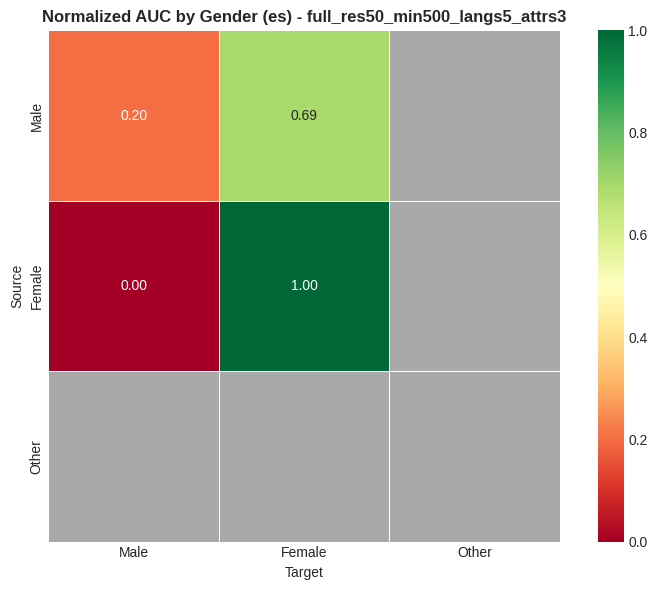


  Attribute: un_subregion
  ----------------------------------------------------------------------------
  📊 Plotting retention curves for es - un_subregion...


INFO: Saved plot: /home/vlr/Workspaces/WikipediaBiasProject/PyProject/data/out/plots/SpotlightWeightSource_0102_0505_full_res50_min500_langs5_attrs3/retention_curves_full_res50_min500_langs5_attrs3/retention_curves_es_un_subregion.png


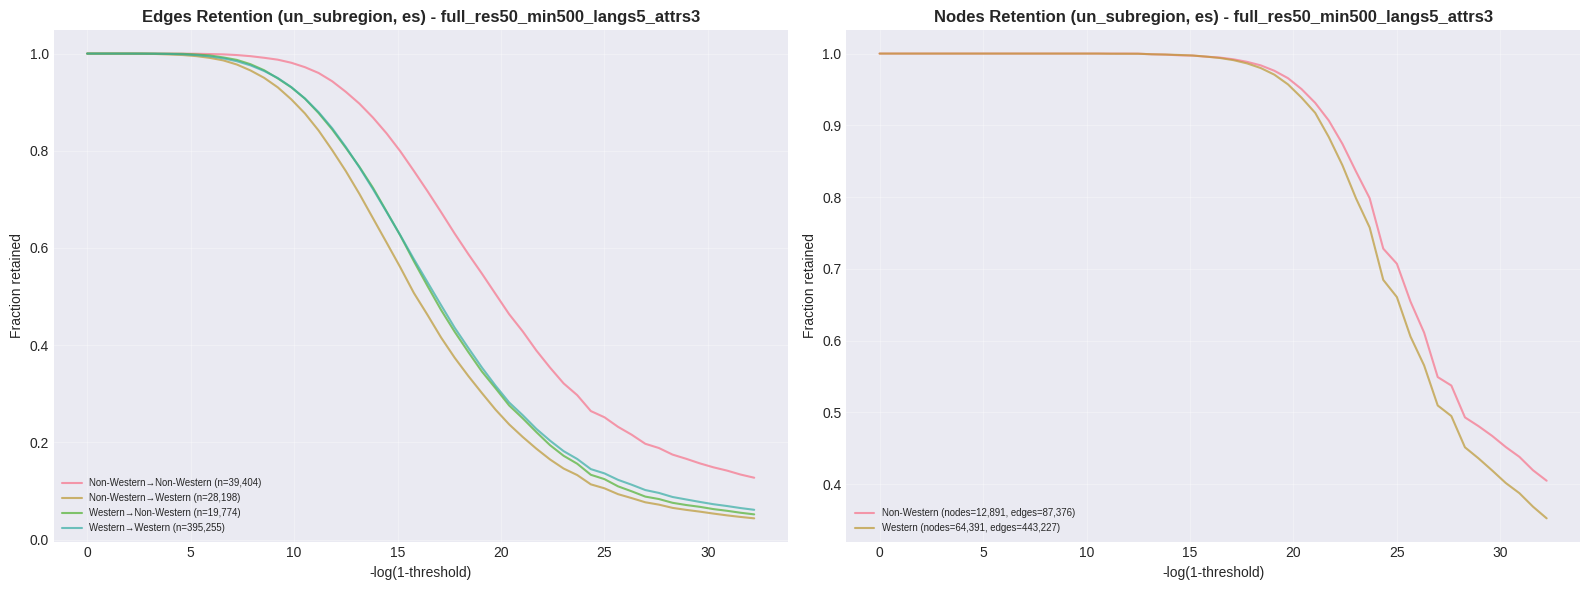

INFO: Saved plot: /home/vlr/Workspaces/WikipediaBiasProject/PyProject/data/out/plots/SpotlightWeightSource_0102_0505_full_res50_min500_langs5_attrs3/heatmaps_full_res50_min500_langs5_attrs3/heatmap_es_un_subregion.png


  🔥 Plotting AUC heatmap for es - un_subregion...


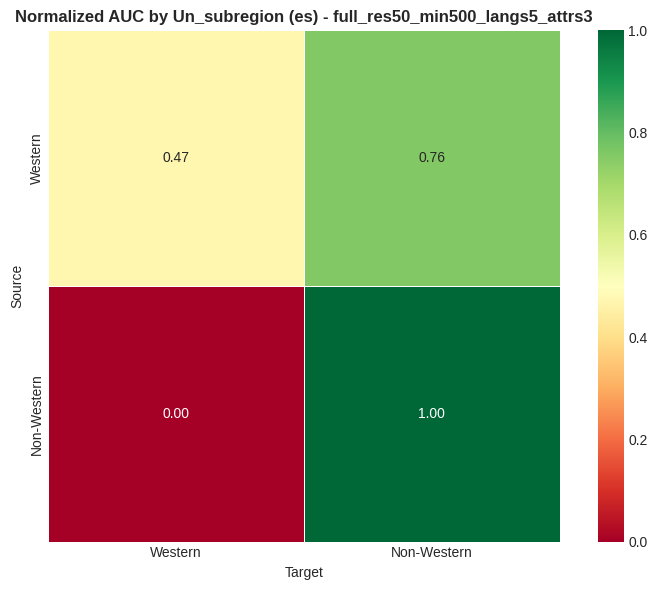


  Attribute: bigperiod_birth
  ----------------------------------------------------------------------------
  📊 Plotting retention curves for es - bigperiod_birth...


INFO: Saved plot: /home/vlr/Workspaces/WikipediaBiasProject/PyProject/data/out/plots/SpotlightWeightSource_0102_0505_full_res50_min500_langs5_attrs3/retention_curves_full_res50_min500_langs5_attrs3/retention_curves_es_bigperiod_birth.png


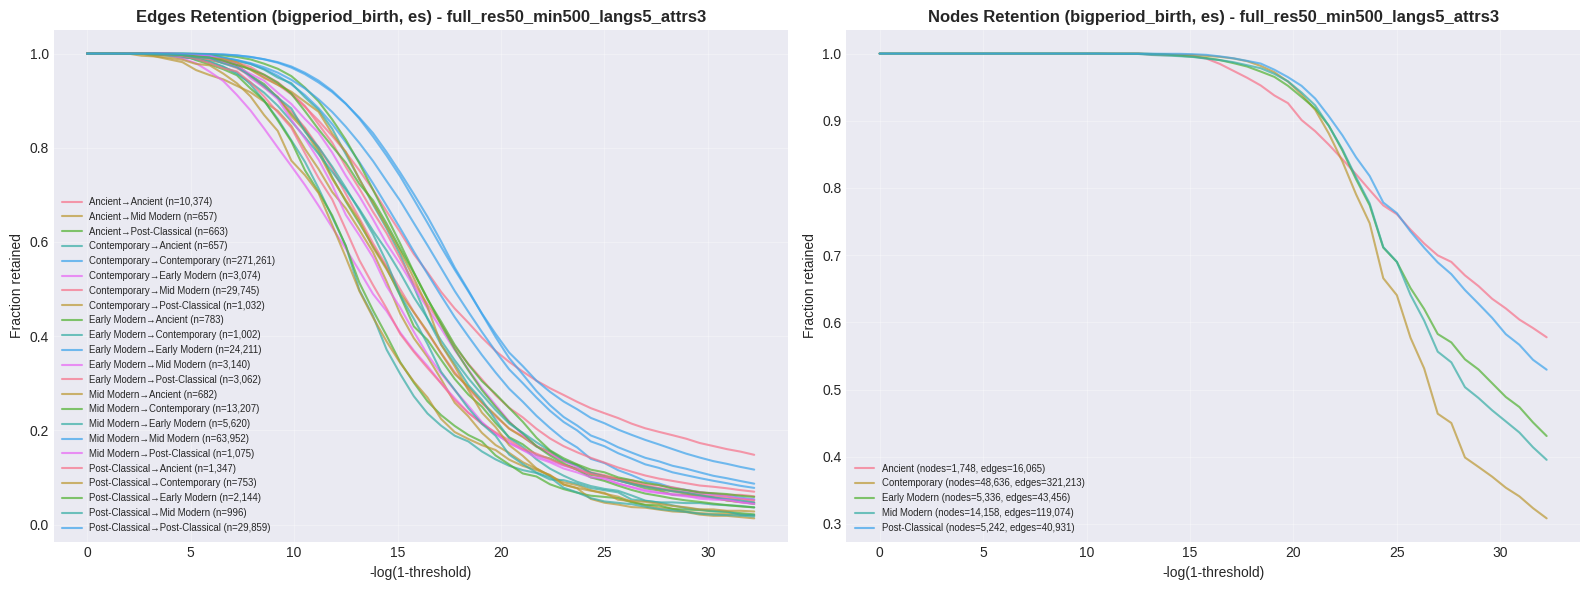

INFO: Saved plot: /home/vlr/Workspaces/WikipediaBiasProject/PyProject/data/out/plots/SpotlightWeightSource_0102_0505_full_res50_min500_langs5_attrs3/heatmaps_full_res50_min500_langs5_attrs3/heatmap_es_bigperiod_birth.png


  🔥 Plotting AUC heatmap for es - bigperiod_birth...


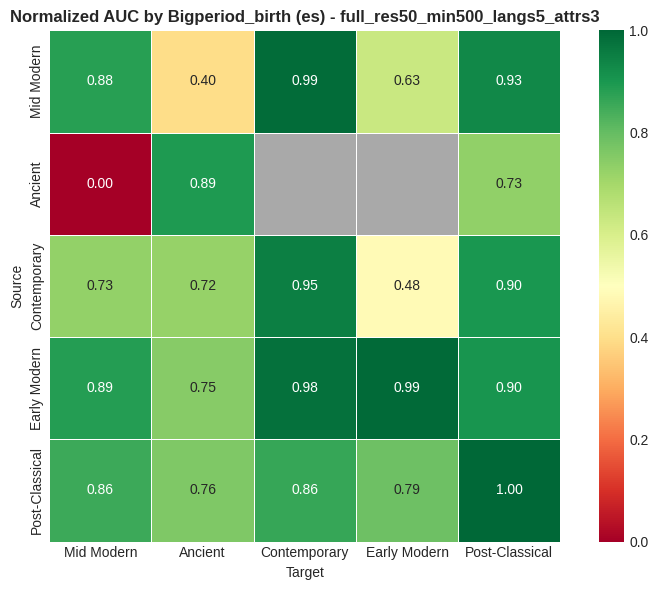


Language: ALL

  Attribute: gender
  ----------------------------------------------------------------------------
  📊 Plotting retention curves for all - gender...


INFO: Saved plot: /home/vlr/Workspaces/WikipediaBiasProject/PyProject/data/out/plots/SpotlightWeightSource_0102_0505_full_res50_min500_langs5_attrs3/retention_curves_full_res50_min500_langs5_attrs3/retention_curves_all_gender.png


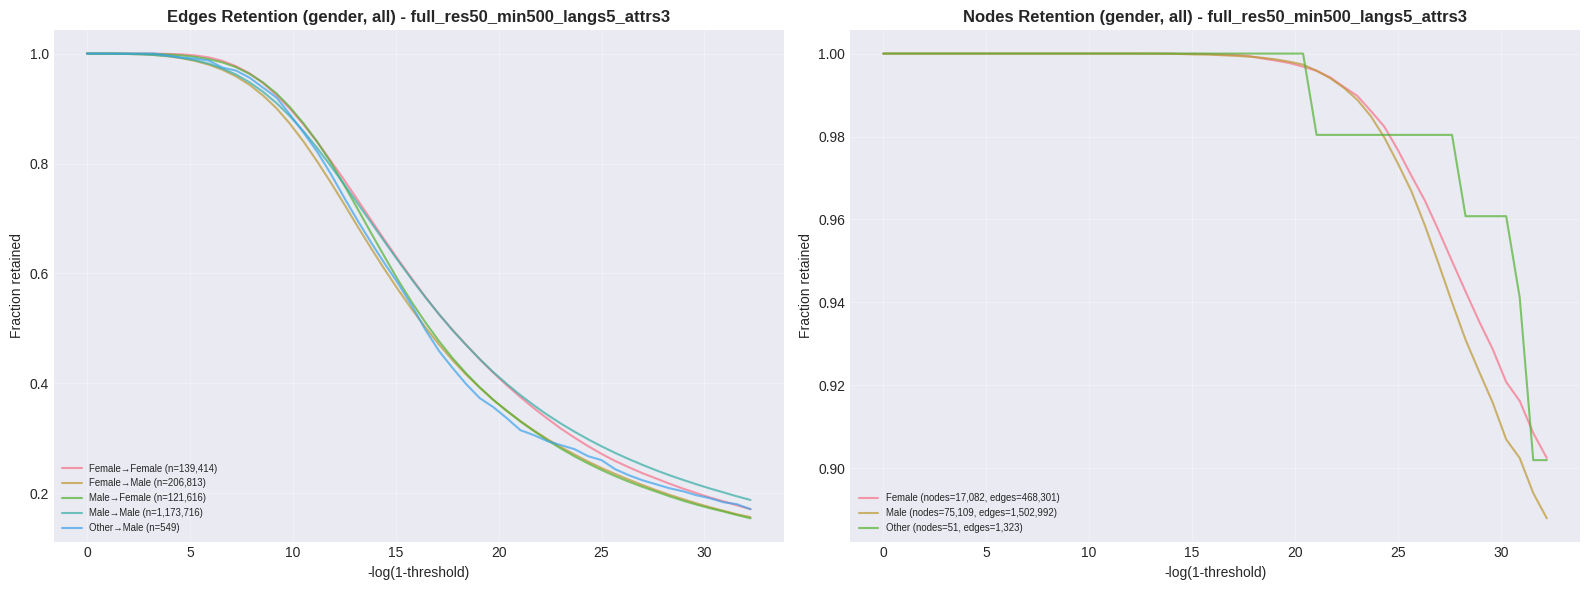

INFO: Saved plot: /home/vlr/Workspaces/WikipediaBiasProject/PyProject/data/out/plots/SpotlightWeightSource_0102_0505_full_res50_min500_langs5_attrs3/heatmaps_full_res50_min500_langs5_attrs3/heatmap_all_gender.png


  🔥 Plotting AUC heatmap for all - gender...


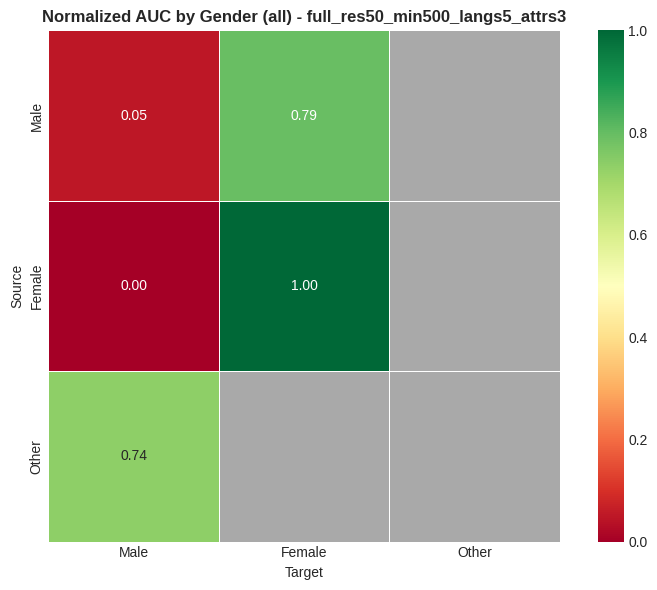


  Attribute: un_subregion
  ----------------------------------------------------------------------------
  📊 Plotting retention curves for all - un_subregion...


INFO: Saved plot: /home/vlr/Workspaces/WikipediaBiasProject/PyProject/data/out/plots/SpotlightWeightSource_0102_0505_full_res50_min500_langs5_attrs3/retention_curves_full_res50_min500_langs5_attrs3/retention_curves_all_un_subregion.png


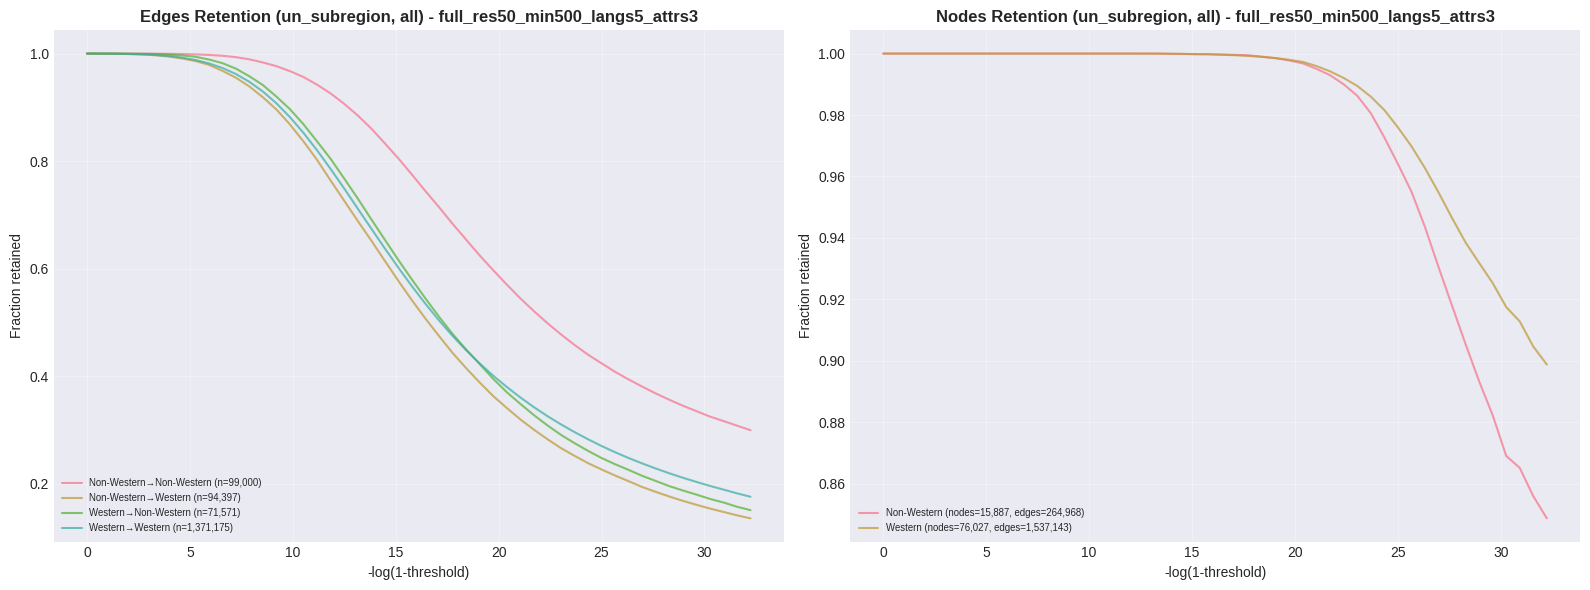

INFO: Saved plot: /home/vlr/Workspaces/WikipediaBiasProject/PyProject/data/out/plots/SpotlightWeightSource_0102_0505_full_res50_min500_langs5_attrs3/heatmaps_full_res50_min500_langs5_attrs3/heatmap_all_un_subregion.png


  🔥 Plotting AUC heatmap for all - un_subregion...


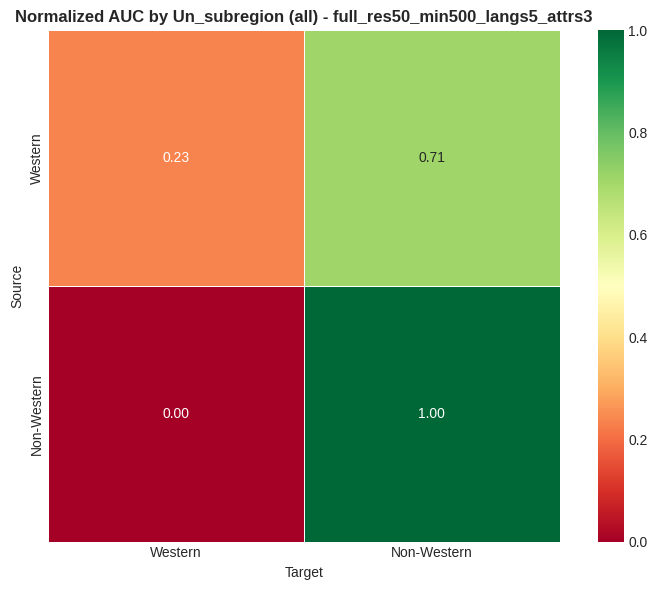


  Attribute: bigperiod_birth
  ----------------------------------------------------------------------------
  📊 Plotting retention curves for all - bigperiod_birth...


INFO: Saved plot: /home/vlr/Workspaces/WikipediaBiasProject/PyProject/data/out/plots/SpotlightWeightSource_0102_0505_full_res50_min500_langs5_attrs3/retention_curves_full_res50_min500_langs5_attrs3/retention_curves_all_bigperiod_birth.png


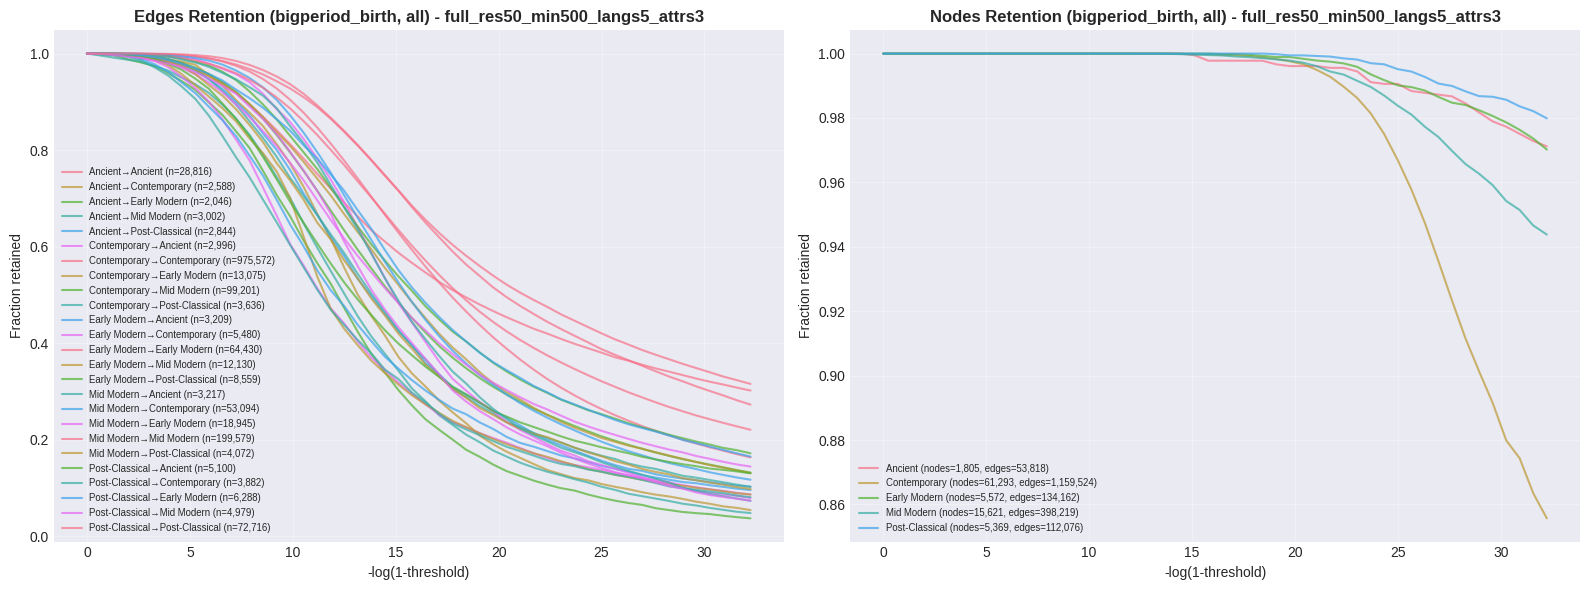

INFO: Saved plot: /home/vlr/Workspaces/WikipediaBiasProject/PyProject/data/out/plots/SpotlightWeightSource_0102_0505_full_res50_min500_langs5_attrs3/heatmaps_full_res50_min500_langs5_attrs3/heatmap_all_bigperiod_birth.png


  🔥 Plotting AUC heatmap for all - bigperiod_birth...


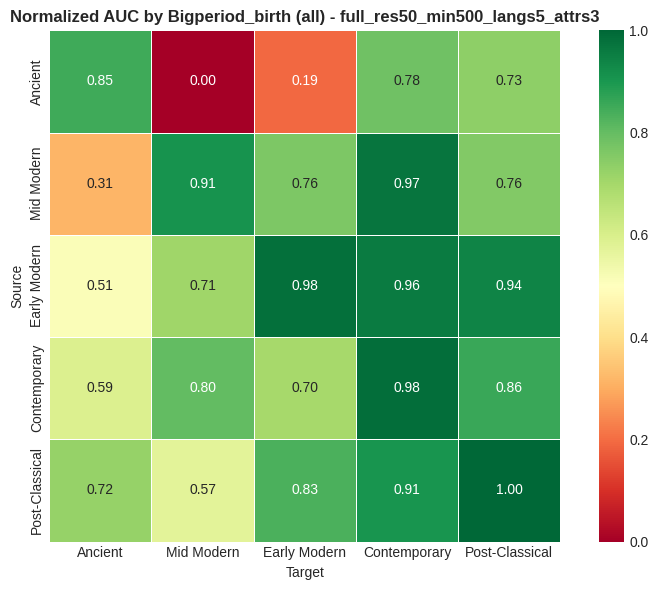


✓ FULL DATASET: Generated 36 total plots
✓ All plots saved to: /home/vlr/Workspaces/WikipediaBiasProject/PyProject/data/out/plots/SpotlightWeightSource_0102_0505_full_res50_min500_langs5_attrs3


In [5]:
print("="*80)
print("GENERATING ALL PLOTS FOR FULL DATASET")
print("="*80)
print(f"Total plots to generate: {len(ALL_LANGUAGES_WITH_AGG) * len(ATTRIBUTES) * 2}")
print()

plot_count = 0

# Generate plots for each language
for lang in ALL_LANGUAGES_WITH_AGG:
    print(f"\n{'='*80}")
    print(f"Language: {lang.upper()}")
    print(f"{'='*80}")
    
    # Generate plots for each attribute
    for attr in ATTRIBUTES:
        print(f"\n  Attribute: {attr}")
        print(f"  {'-'*76}")
        
        # Plot retention curves
        print(f"  📊 Plotting retention curves for {lang} - {attr}...")
        analysis.plot_retention_results(
            retention_full,
            languages=[lang],
            attributes=[attr],
            min_edges=MIN_EDGES,
            plot_type='curves',
            figsize=(16, 6),
            save_dir=OUTPUT_DIRS_FULL['base']
        )
        plot_count += 1
        
        # Plot AUC heatmap
        print(f"  🔥 Plotting AUC heatmap for {lang} - {attr}...")
        analysis.plot_retention_results(
            retention_full,
            languages=[lang],
            attributes=[attr],
            min_edges=MIN_EDGES,
            plot_type='heatmaps',
            figsize=(10, 8),
            save_dir=OUTPUT_DIRS_FULL['base']
        )
        plot_count += 1

print(f"\n{'='*80}")
print(f"✓ FULL DATASET: Generated {plot_count} total plots")
print(f"✓ All plots saved to: {OUTPUT_DIRS_FULL['base']}")
print(f"{'='*80}")

---
# Part 2: Time-Restricted Dataset Analysis

Analyzing data filtered to individuals born between 1750-1950.

## Run Time-Restricted Analysis

In [6]:
print("="*80)
print(f"RUNNING TIME-RESTRICTED DATASET ANALYSIS ({MIN_YEAR}-{MAX_YEAR})")
print("="*80)

# Build output directories
OUTPUT_DIRS_RESTRICTED = analysis.build_analysis_output_dirs(
    base_output_dir=BASE_OUTPUT_DIR,
    dataset_name=DATASET_NAME,
    filter_description=f"restricted_{MIN_YEAR}_{MAX_YEAR}",
    resolution=RESOLUTION,
    min_edges=MIN_EDGES,
    selected_languages=SELECTED_LANGUAGES,
    attributes=ATTRIBUTES,
    logspace_lower_bound=LOGSPACE_LOWER_BOUND
)

print(f"Output directory: {OUTPUT_DIRS_RESTRICTED['base']}")

# Try to load cached results first
print("\nChecking for cached results...")
retention_restricted = analysis.load_cached_analysis_results(
    OUTPUT_DIRS_RESTRICTED,
    ALL_LANGUAGES_WITH_AGG,
    ATTRIBUTES
)

if retention_restricted is not None:
    print("✓ Loaded cached results")
else:
    print("Cache not found. Running fresh analysis...")
    
    # Create year filter
    year_filter = filters.restrict_years(MIN_YEAR, MAX_YEAR)
    
    # Run analysis
    retention_restricted = analysis.run_bias_analysis(
        edges_df=edges_df,
        meta_df=meta_df,
        edge_id_map={
            'source_wikidata_id': 'src',
            'target_wikidata_id': 'trg',
            'weight': 'nij'
        },
        meta_id_col='wikidata_id',
        selected_languages=SELECTED_LANGUAGES,
        min_edges=MIN_EDGES,
        resolution=RESOLUTION,
        filter_zero_weights=True,
        language_col='language_code',
        add_aggregated_all=True,
        pre_transform_filters=[year_filter],
        post_transform_filters=None,
        dataset_label=f'restricted_{MIN_YEAR}_{MAX_YEAR}'
    )
    
    # Save results
    print("\nSaving results...")
    analysis.save_analysis_results(
        retention_restricted, 
        OUTPUT_DIRS_RESTRICTED, 
        ALL_LANGUAGES_WITH_AGG, 
        ATTRIBUTES,
        resolution=RESOLUTION,
        min_edges=MIN_EDGES,
        logspace_lower_bound=LOGSPACE_LOWER_BOUND,
        dataset_name=DATASET_NAME,
        filter_description=f'restricted_{MIN_YEAR}_{MAX_YEAR}'
    )
    print("✓ Results saved")

print("\n✓ Time-restricted dataset analysis complete")

INFO: Found cached results. Loading...
INFO: Cached results loaded successfully


RUNNING TIME-RESTRICTED DATASET ANALYSIS (1750-1950)
Output directory: /home/vlr/Workspaces/WikipediaBiasProject/PyProject/data/out/plots/SpotlightWeightSource_0102_0505_restricted_1750_1950_res50_min500_langs5_attrs3

Checking for cached results...
✓ Loaded cached results

✓ Time-restricted dataset analysis complete


## Generate ALL Plots for Time-Restricted Dataset

This will generate:
- Retention curves (edge + node) for each language-attribute combination
- AUC heatmaps for each language-attribute combination

GENERATING ALL PLOTS FOR TIME-RESTRICTED DATASET (1750-1950)
Total plots to generate: 36


Language: EN

  Attribute: gender
  ----------------------------------------------------------------------------
  📊 Plotting retention curves for en - gender...


INFO: Saved plot: /home/vlr/Workspaces/WikipediaBiasProject/PyProject/data/out/plots/SpotlightWeightSource_0102_0505_restricted_1750_1950_res50_min500_langs5_attrs3/retention_curves_restricted_1750_1950_res50_min500_langs5_attrs3/retention_curves_en_gender.png


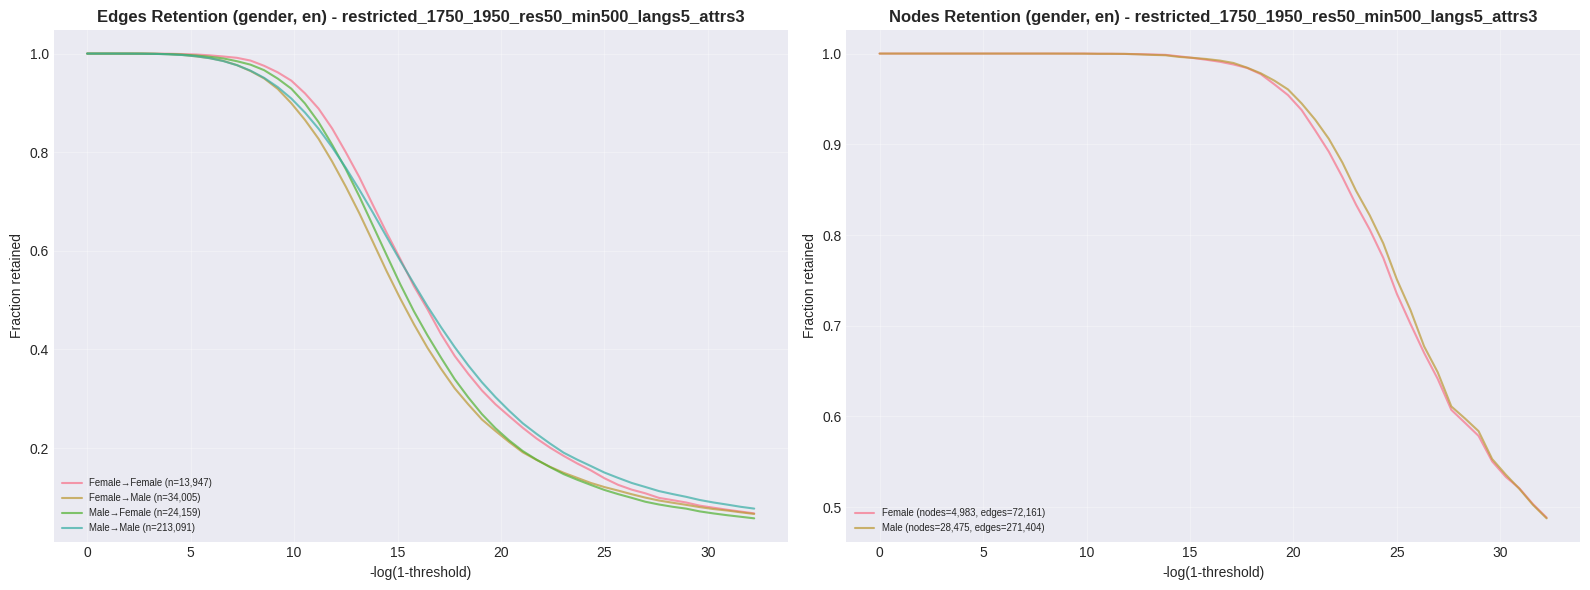

INFO: Saved plot: /home/vlr/Workspaces/WikipediaBiasProject/PyProject/data/out/plots/SpotlightWeightSource_0102_0505_restricted_1750_1950_res50_min500_langs5_attrs3/heatmaps_restricted_1750_1950_res50_min500_langs5_attrs3/heatmap_en_gender.png


  🔥 Plotting AUC heatmap for en - gender...


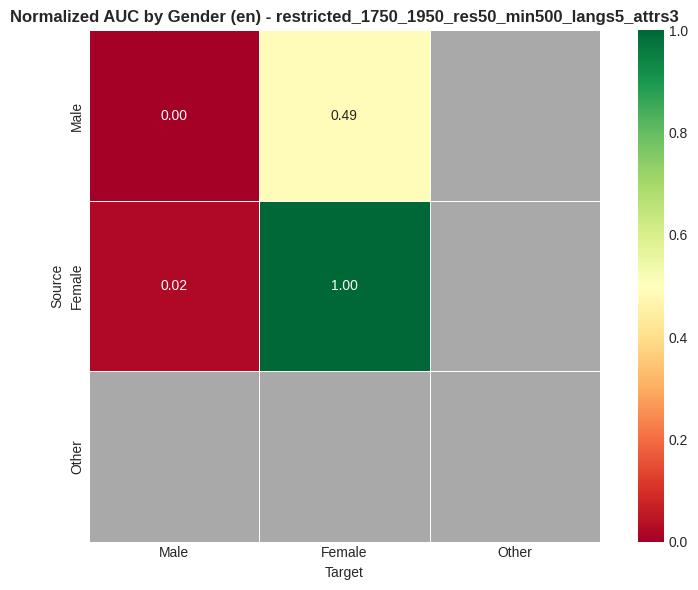


  Attribute: un_subregion
  ----------------------------------------------------------------------------
  📊 Plotting retention curves for en - un_subregion...


INFO: Saved plot: /home/vlr/Workspaces/WikipediaBiasProject/PyProject/data/out/plots/SpotlightWeightSource_0102_0505_restricted_1750_1950_res50_min500_langs5_attrs3/retention_curves_restricted_1750_1950_res50_min500_langs5_attrs3/retention_curves_en_un_subregion.png


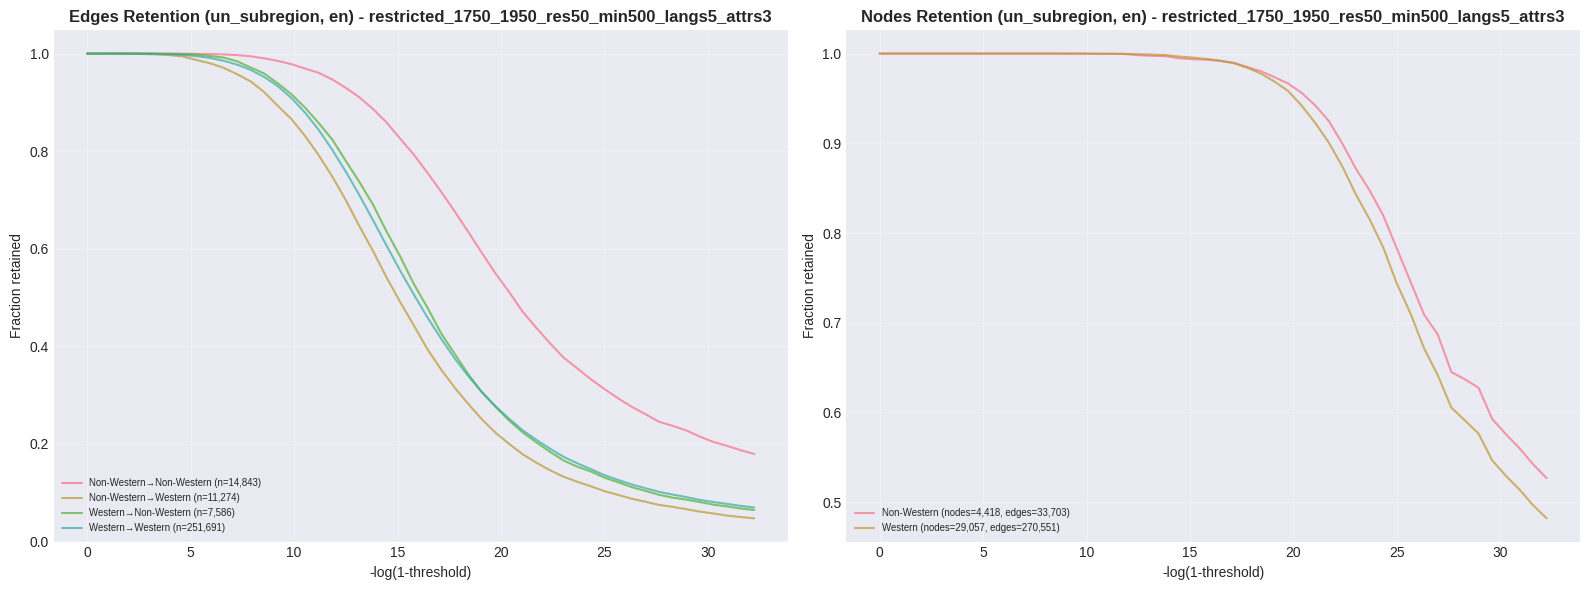

INFO: Saved plot: /home/vlr/Workspaces/WikipediaBiasProject/PyProject/data/out/plots/SpotlightWeightSource_0102_0505_restricted_1750_1950_res50_min500_langs5_attrs3/heatmaps_restricted_1750_1950_res50_min500_langs5_attrs3/heatmap_en_un_subregion.png


  🔥 Plotting AUC heatmap for en - un_subregion...


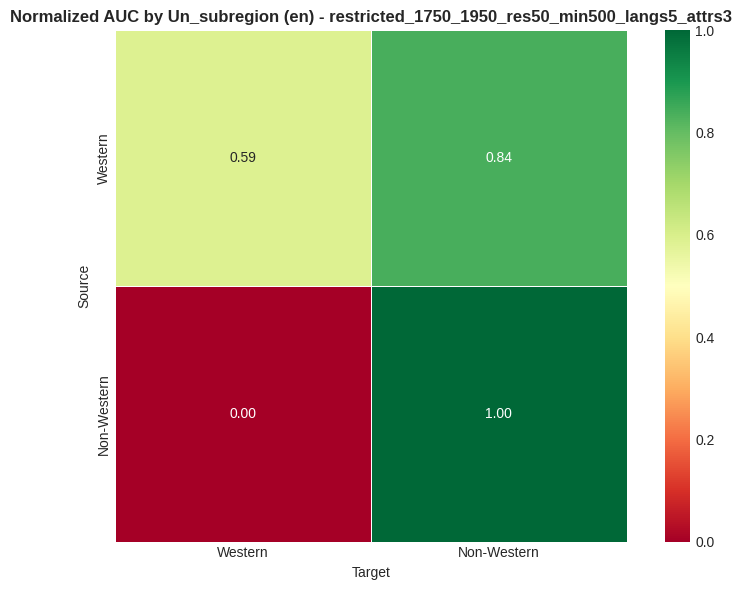


  Attribute: bigperiod_birth
  ----------------------------------------------------------------------------
  📊 Plotting retention curves for en - bigperiod_birth...


INFO: Saved plot: /home/vlr/Workspaces/WikipediaBiasProject/PyProject/data/out/plots/SpotlightWeightSource_0102_0505_restricted_1750_1950_res50_min500_langs5_attrs3/retention_curves_restricted_1750_1950_res50_min500_langs5_attrs3/retention_curves_en_bigperiod_birth.png


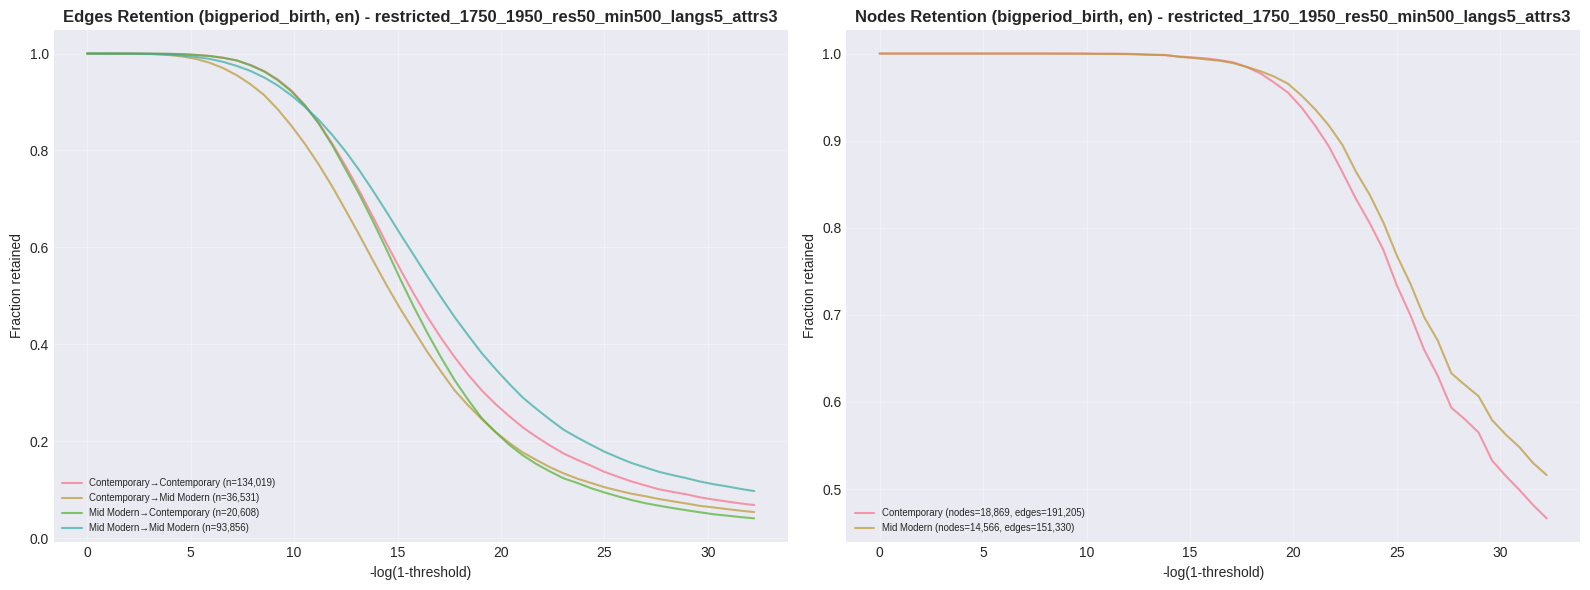

INFO: Saved plot: /home/vlr/Workspaces/WikipediaBiasProject/PyProject/data/out/plots/SpotlightWeightSource_0102_0505_restricted_1750_1950_res50_min500_langs5_attrs3/heatmaps_restricted_1750_1950_res50_min500_langs5_attrs3/heatmap_en_bigperiod_birth.png


  🔥 Plotting AUC heatmap for en - bigperiod_birth...


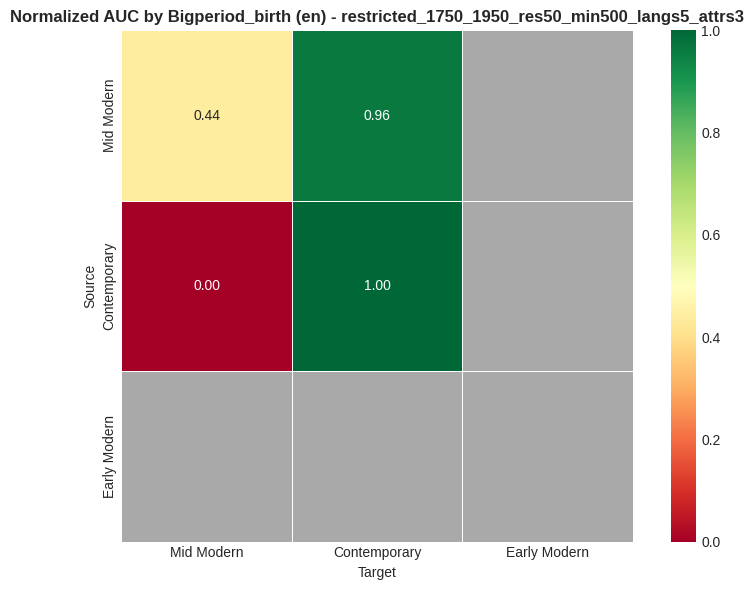


Language: DE

  Attribute: gender
  ----------------------------------------------------------------------------
  📊 Plotting retention curves for de - gender...


INFO: Saved plot: /home/vlr/Workspaces/WikipediaBiasProject/PyProject/data/out/plots/SpotlightWeightSource_0102_0505_restricted_1750_1950_res50_min500_langs5_attrs3/retention_curves_restricted_1750_1950_res50_min500_langs5_attrs3/retention_curves_de_gender.png


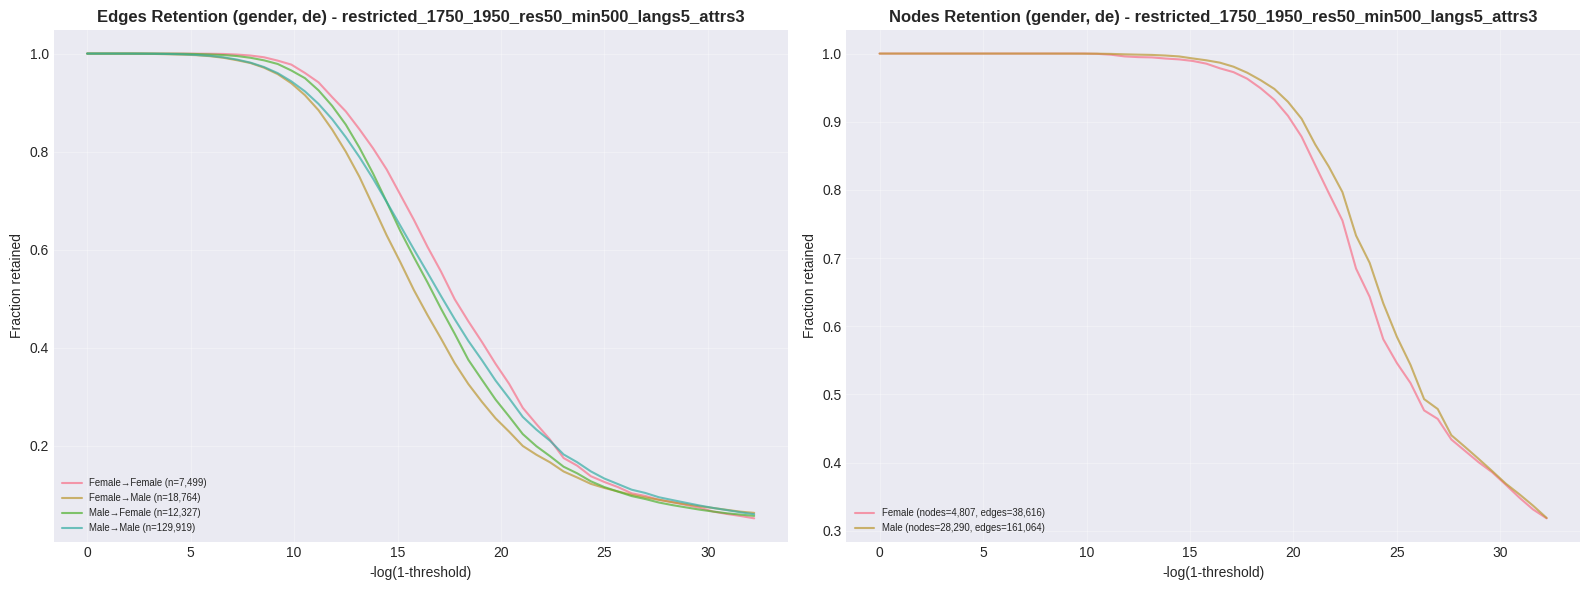

INFO: Saved plot: /home/vlr/Workspaces/WikipediaBiasProject/PyProject/data/out/plots/SpotlightWeightSource_0102_0505_restricted_1750_1950_res50_min500_langs5_attrs3/heatmaps_restricted_1750_1950_res50_min500_langs5_attrs3/heatmap_de_gender.png


  🔥 Plotting AUC heatmap for de - gender...


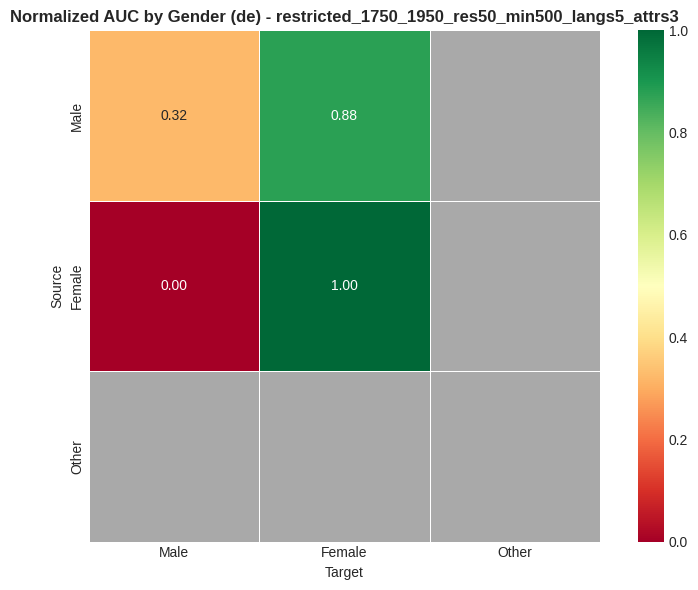


  Attribute: un_subregion
  ----------------------------------------------------------------------------
  📊 Plotting retention curves for de - un_subregion...


INFO: Saved plot: /home/vlr/Workspaces/WikipediaBiasProject/PyProject/data/out/plots/SpotlightWeightSource_0102_0505_restricted_1750_1950_res50_min500_langs5_attrs3/retention_curves_restricted_1750_1950_res50_min500_langs5_attrs3/retention_curves_de_un_subregion.png


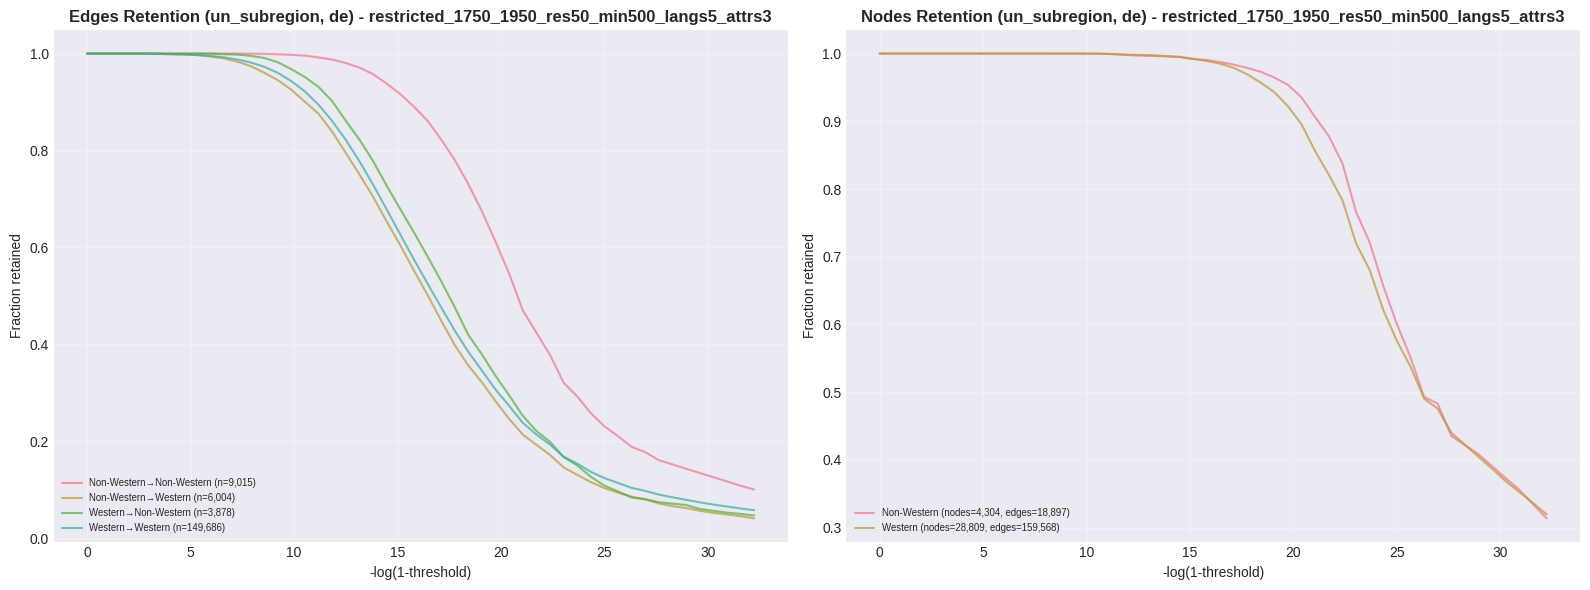

INFO: Saved plot: /home/vlr/Workspaces/WikipediaBiasProject/PyProject/data/out/plots/SpotlightWeightSource_0102_0505_restricted_1750_1950_res50_min500_langs5_attrs3/heatmaps_restricted_1750_1950_res50_min500_langs5_attrs3/heatmap_de_un_subregion.png


  🔥 Plotting AUC heatmap for de - un_subregion...


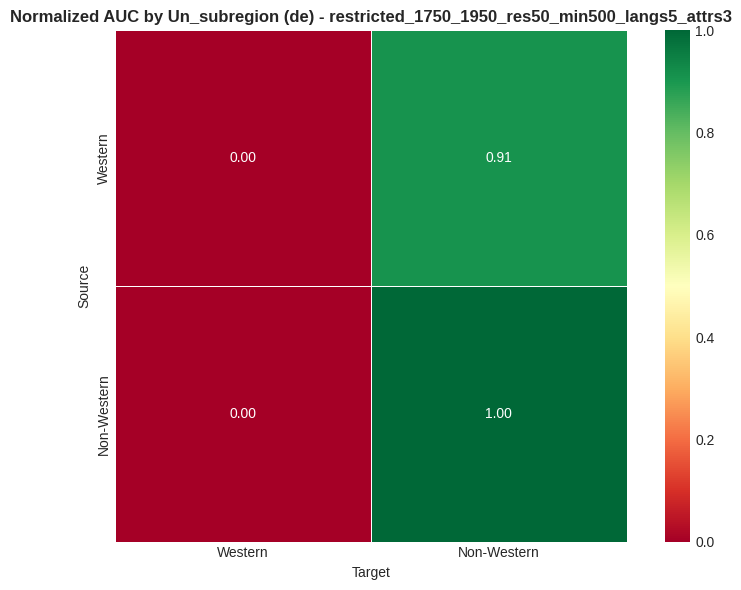


  Attribute: bigperiod_birth
  ----------------------------------------------------------------------------
  📊 Plotting retention curves for de - bigperiod_birth...


INFO: Saved plot: /home/vlr/Workspaces/WikipediaBiasProject/PyProject/data/out/plots/SpotlightWeightSource_0102_0505_restricted_1750_1950_res50_min500_langs5_attrs3/retention_curves_restricted_1750_1950_res50_min500_langs5_attrs3/retention_curves_de_bigperiod_birth.png


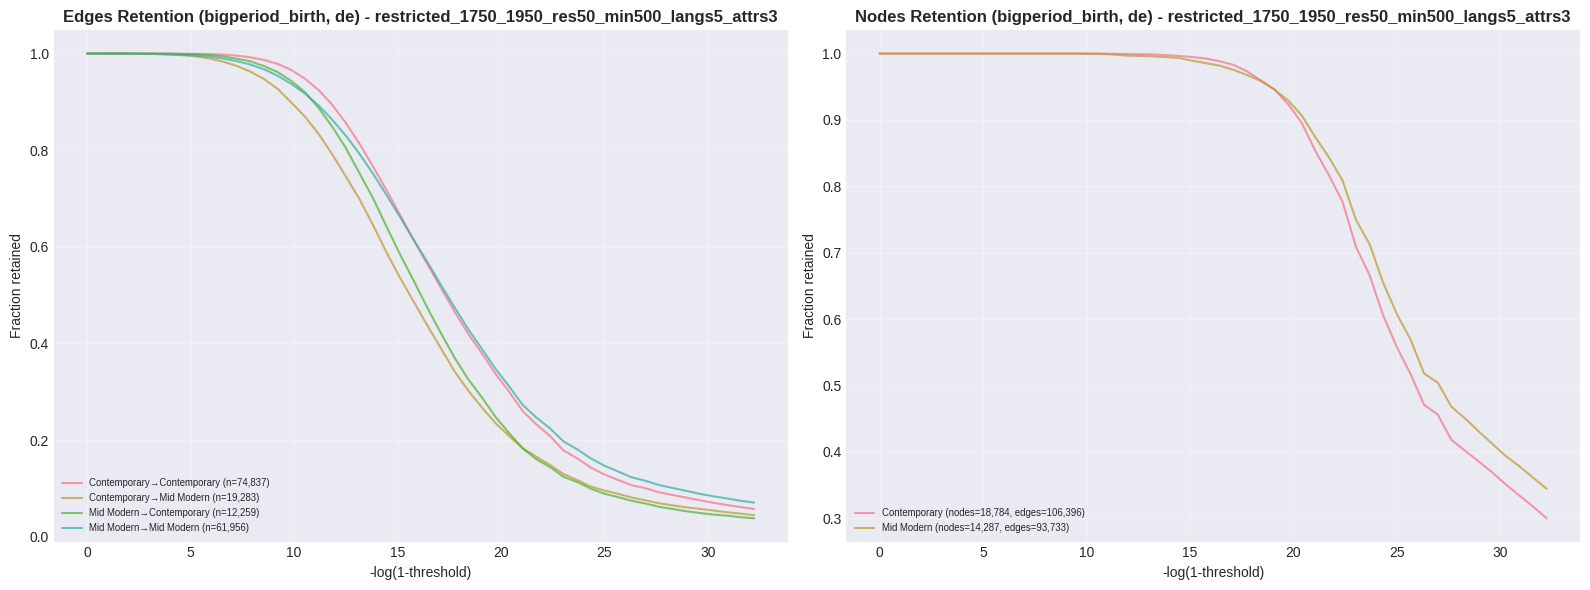

INFO: Saved plot: /home/vlr/Workspaces/WikipediaBiasProject/PyProject/data/out/plots/SpotlightWeightSource_0102_0505_restricted_1750_1950_res50_min500_langs5_attrs3/heatmaps_restricted_1750_1950_res50_min500_langs5_attrs3/heatmap_de_bigperiod_birth.png


  🔥 Plotting AUC heatmap for de - bigperiod_birth...


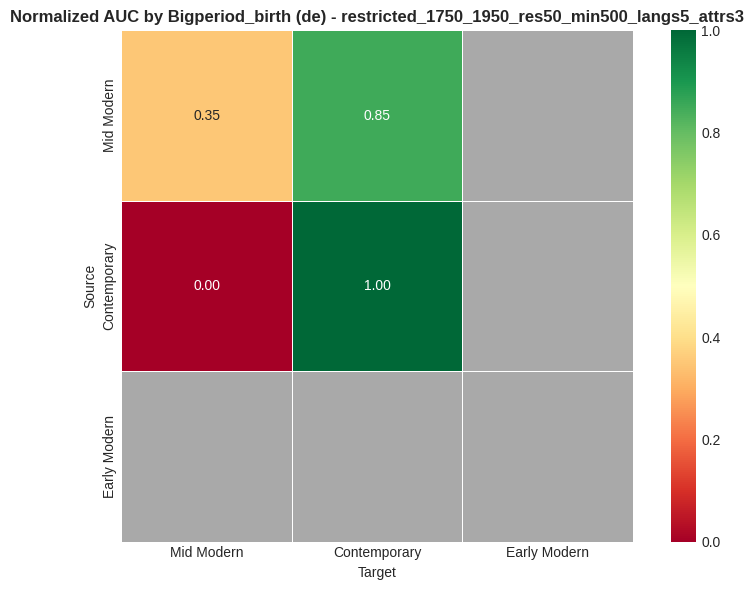


Language: FR

  Attribute: gender
  ----------------------------------------------------------------------------
  📊 Plotting retention curves for fr - gender...


INFO: Saved plot: /home/vlr/Workspaces/WikipediaBiasProject/PyProject/data/out/plots/SpotlightWeightSource_0102_0505_restricted_1750_1950_res50_min500_langs5_attrs3/retention_curves_restricted_1750_1950_res50_min500_langs5_attrs3/retention_curves_fr_gender.png


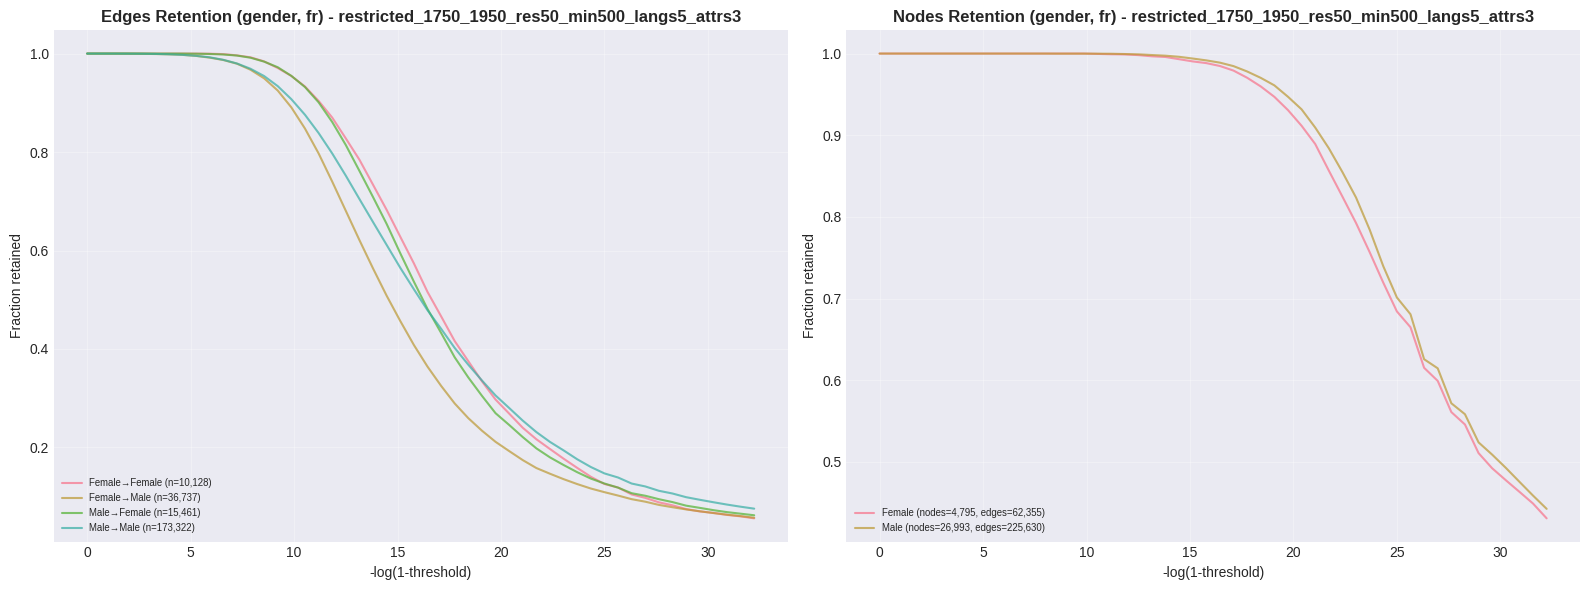

INFO: Saved plot: /home/vlr/Workspaces/WikipediaBiasProject/PyProject/data/out/plots/SpotlightWeightSource_0102_0505_restricted_1750_1950_res50_min500_langs5_attrs3/heatmaps_restricted_1750_1950_res50_min500_langs5_attrs3/heatmap_fr_gender.png


  🔥 Plotting AUC heatmap for fr - gender...


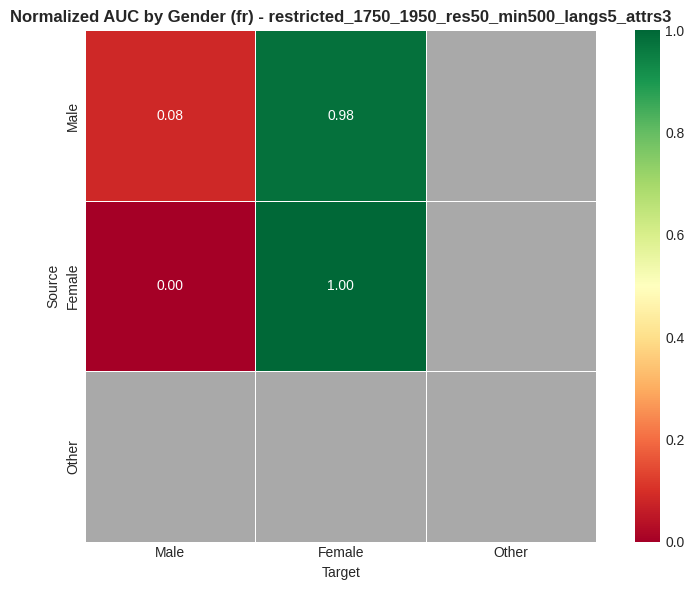


  Attribute: un_subregion
  ----------------------------------------------------------------------------
  📊 Plotting retention curves for fr - un_subregion...


INFO: Saved plot: /home/vlr/Workspaces/WikipediaBiasProject/PyProject/data/out/plots/SpotlightWeightSource_0102_0505_restricted_1750_1950_res50_min500_langs5_attrs3/retention_curves_restricted_1750_1950_res50_min500_langs5_attrs3/retention_curves_fr_un_subregion.png


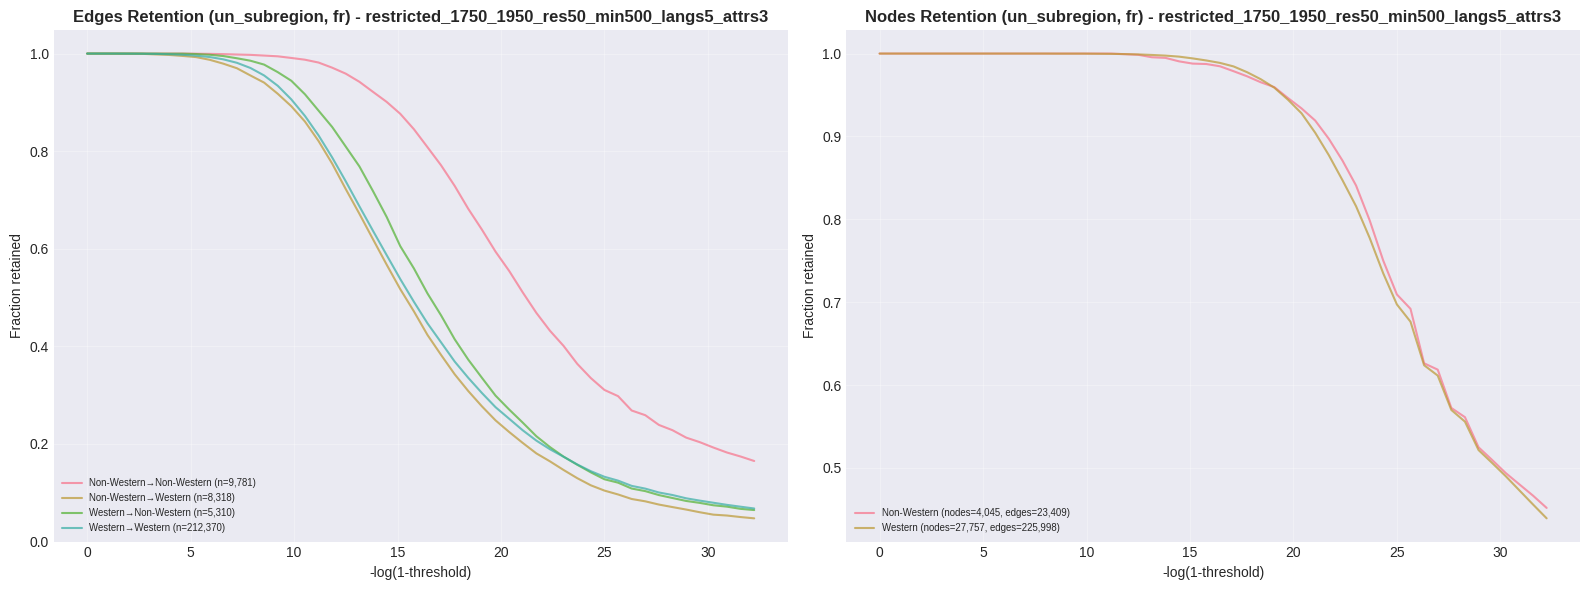

INFO: Saved plot: /home/vlr/Workspaces/WikipediaBiasProject/PyProject/data/out/plots/SpotlightWeightSource_0102_0505_restricted_1750_1950_res50_min500_langs5_attrs3/heatmaps_restricted_1750_1950_res50_min500_langs5_attrs3/heatmap_fr_un_subregion.png


  🔥 Plotting AUC heatmap for fr - un_subregion...


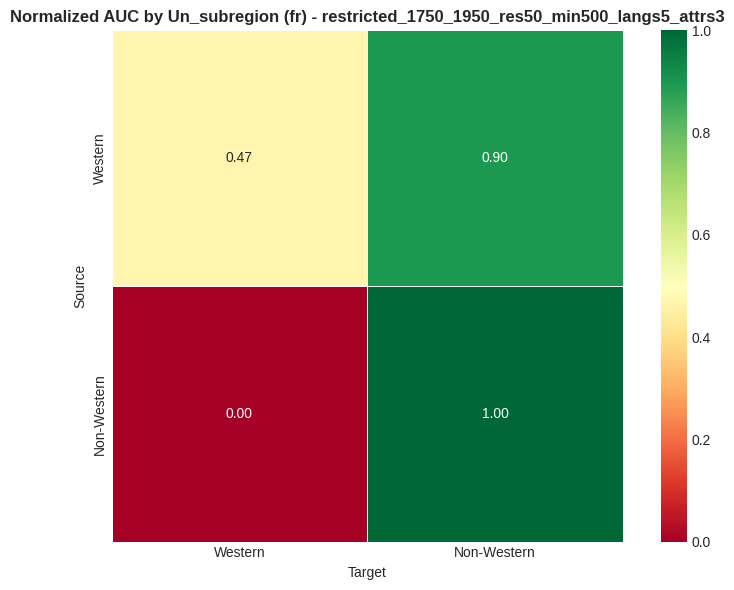


  Attribute: bigperiod_birth
  ----------------------------------------------------------------------------
  📊 Plotting retention curves for fr - bigperiod_birth...


INFO: Saved plot: /home/vlr/Workspaces/WikipediaBiasProject/PyProject/data/out/plots/SpotlightWeightSource_0102_0505_restricted_1750_1950_res50_min500_langs5_attrs3/retention_curves_restricted_1750_1950_res50_min500_langs5_attrs3/retention_curves_fr_bigperiod_birth.png


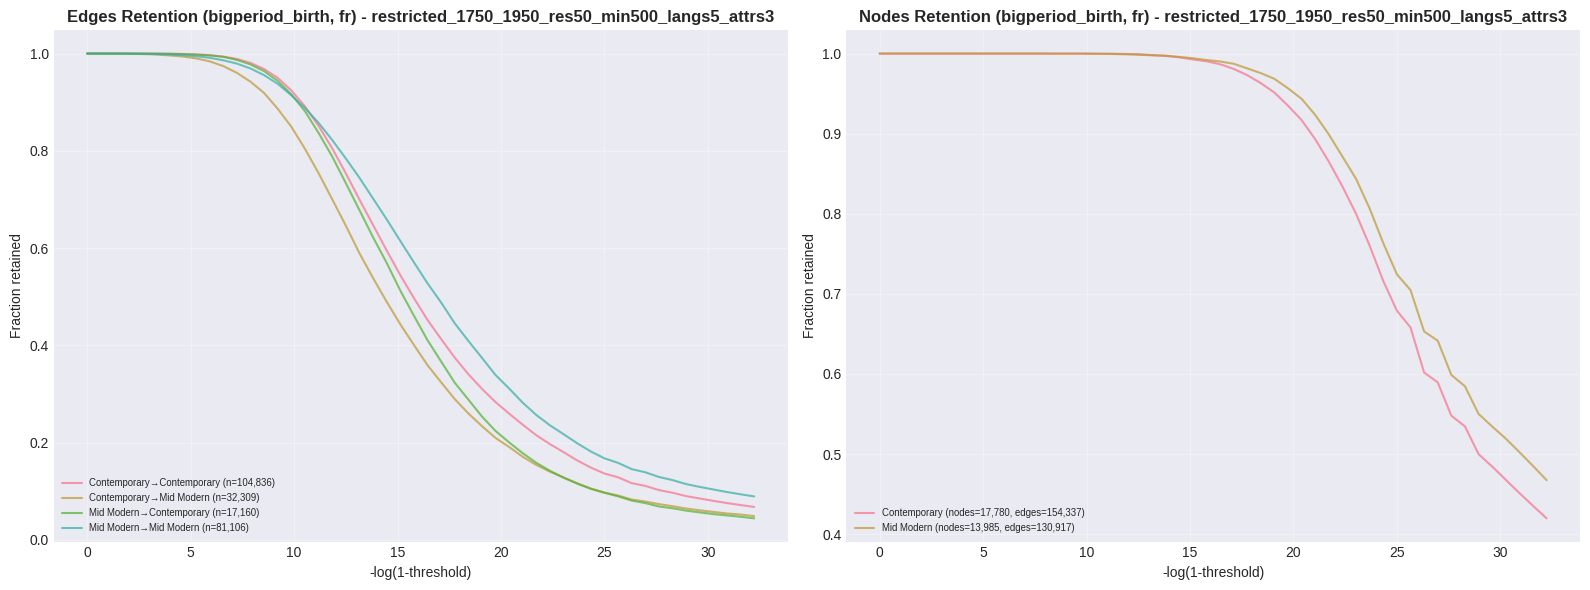

INFO: Saved plot: /home/vlr/Workspaces/WikipediaBiasProject/PyProject/data/out/plots/SpotlightWeightSource_0102_0505_restricted_1750_1950_res50_min500_langs5_attrs3/heatmaps_restricted_1750_1950_res50_min500_langs5_attrs3/heatmap_fr_bigperiod_birth.png


  🔥 Plotting AUC heatmap for fr - bigperiod_birth...


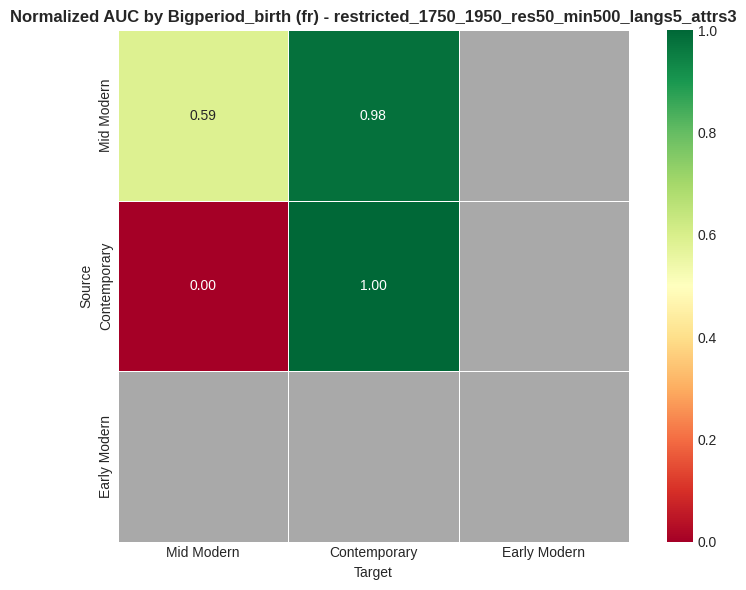


Language: IT

  Attribute: gender
  ----------------------------------------------------------------------------
  📊 Plotting retention curves for it - gender...


INFO: Saved plot: /home/vlr/Workspaces/WikipediaBiasProject/PyProject/data/out/plots/SpotlightWeightSource_0102_0505_restricted_1750_1950_res50_min500_langs5_attrs3/retention_curves_restricted_1750_1950_res50_min500_langs5_attrs3/retention_curves_it_gender.png


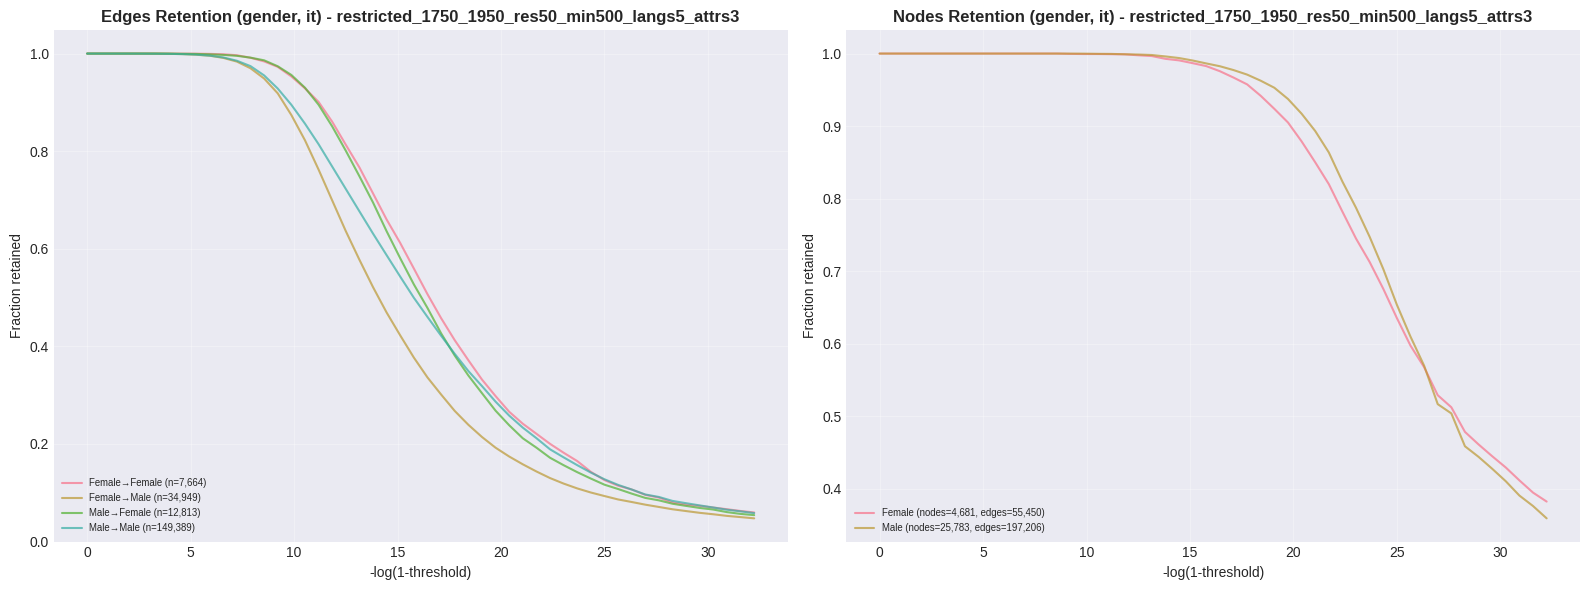

INFO: Saved plot: /home/vlr/Workspaces/WikipediaBiasProject/PyProject/data/out/plots/SpotlightWeightSource_0102_0505_restricted_1750_1950_res50_min500_langs5_attrs3/heatmaps_restricted_1750_1950_res50_min500_langs5_attrs3/heatmap_it_gender.png


  🔥 Plotting AUC heatmap for it - gender...


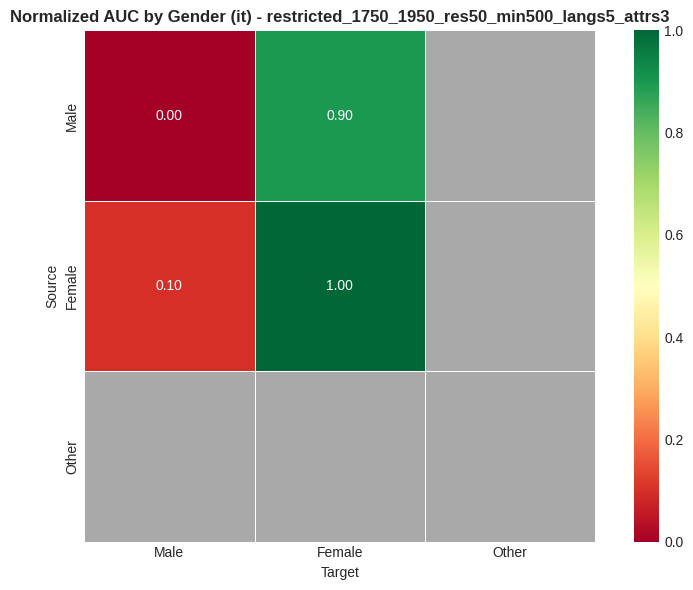


  Attribute: un_subregion
  ----------------------------------------------------------------------------
  📊 Plotting retention curves for it - un_subregion...


INFO: Saved plot: /home/vlr/Workspaces/WikipediaBiasProject/PyProject/data/out/plots/SpotlightWeightSource_0102_0505_restricted_1750_1950_res50_min500_langs5_attrs3/retention_curves_restricted_1750_1950_res50_min500_langs5_attrs3/retention_curves_it_un_subregion.png


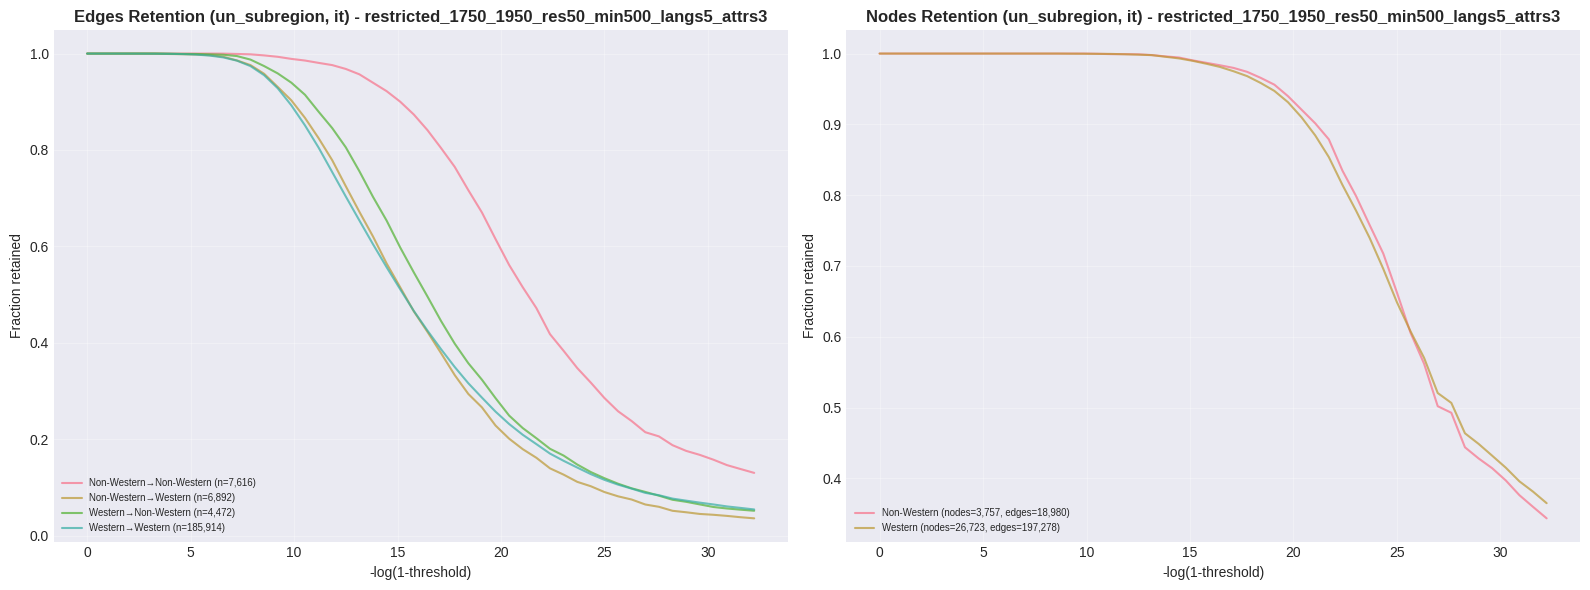

INFO: Saved plot: /home/vlr/Workspaces/WikipediaBiasProject/PyProject/data/out/plots/SpotlightWeightSource_0102_0505_restricted_1750_1950_res50_min500_langs5_attrs3/heatmaps_restricted_1750_1950_res50_min500_langs5_attrs3/heatmap_it_un_subregion.png


  🔥 Plotting AUC heatmap for it - un_subregion...


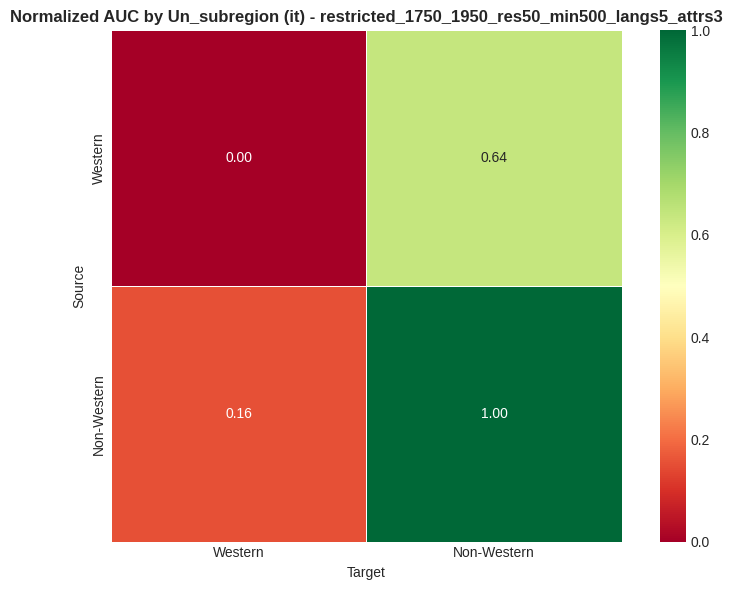


  Attribute: bigperiod_birth
  ----------------------------------------------------------------------------
  📊 Plotting retention curves for it - bigperiod_birth...


INFO: Saved plot: /home/vlr/Workspaces/WikipediaBiasProject/PyProject/data/out/plots/SpotlightWeightSource_0102_0505_restricted_1750_1950_res50_min500_langs5_attrs3/retention_curves_restricted_1750_1950_res50_min500_langs5_attrs3/retention_curves_it_bigperiod_birth.png


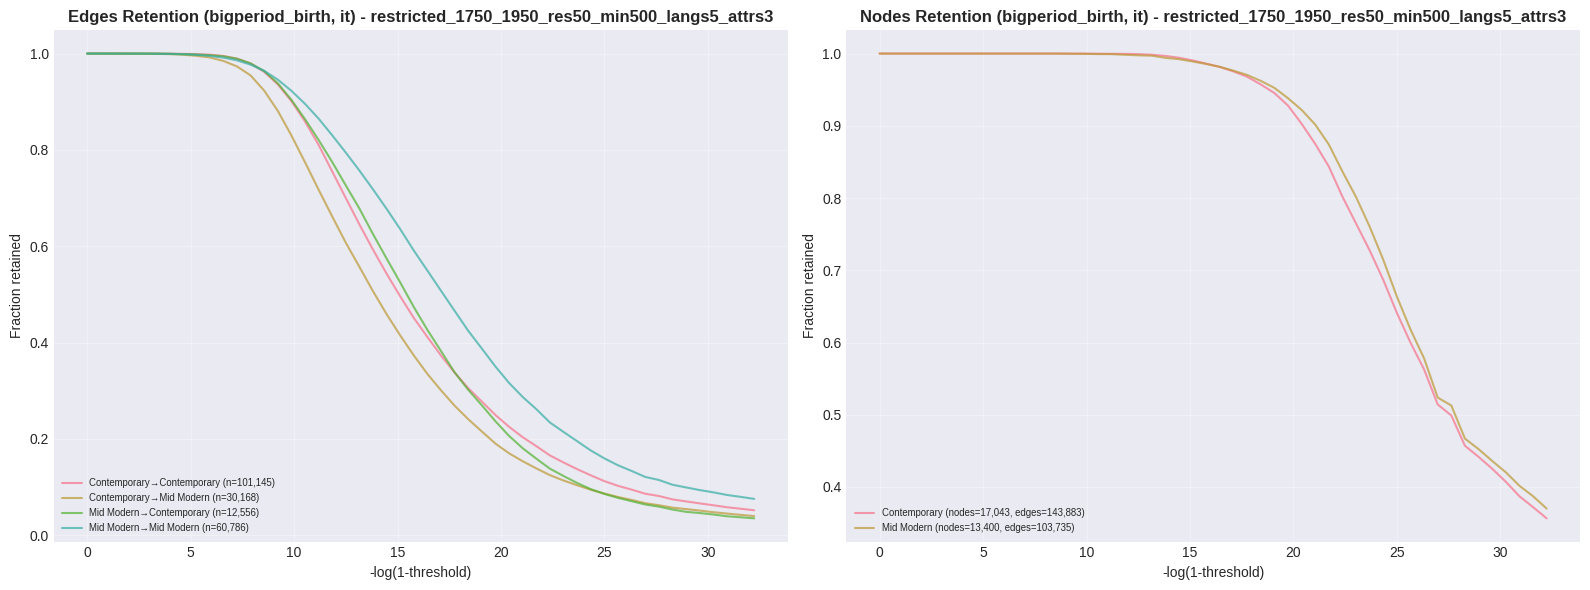

  🔥 Plotting AUC heatmap for it - bigperiod_birth...


INFO: Saved plot: /home/vlr/Workspaces/WikipediaBiasProject/PyProject/data/out/plots/SpotlightWeightSource_0102_0505_restricted_1750_1950_res50_min500_langs5_attrs3/heatmaps_restricted_1750_1950_res50_min500_langs5_attrs3/heatmap_it_bigperiod_birth.png


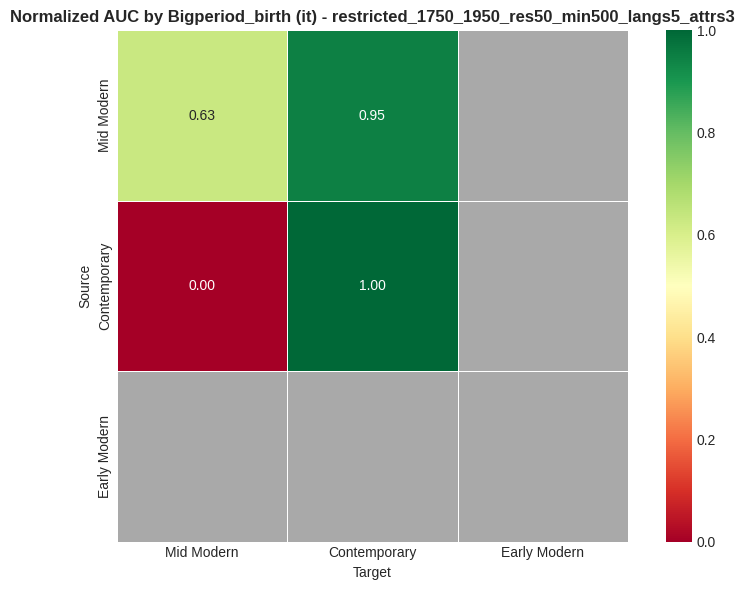


Language: ES

  Attribute: gender
  ----------------------------------------------------------------------------
  📊 Plotting retention curves for es - gender...


INFO: Saved plot: /home/vlr/Workspaces/WikipediaBiasProject/PyProject/data/out/plots/SpotlightWeightSource_0102_0505_restricted_1750_1950_res50_min500_langs5_attrs3/retention_curves_restricted_1750_1950_res50_min500_langs5_attrs3/retention_curves_es_gender.png


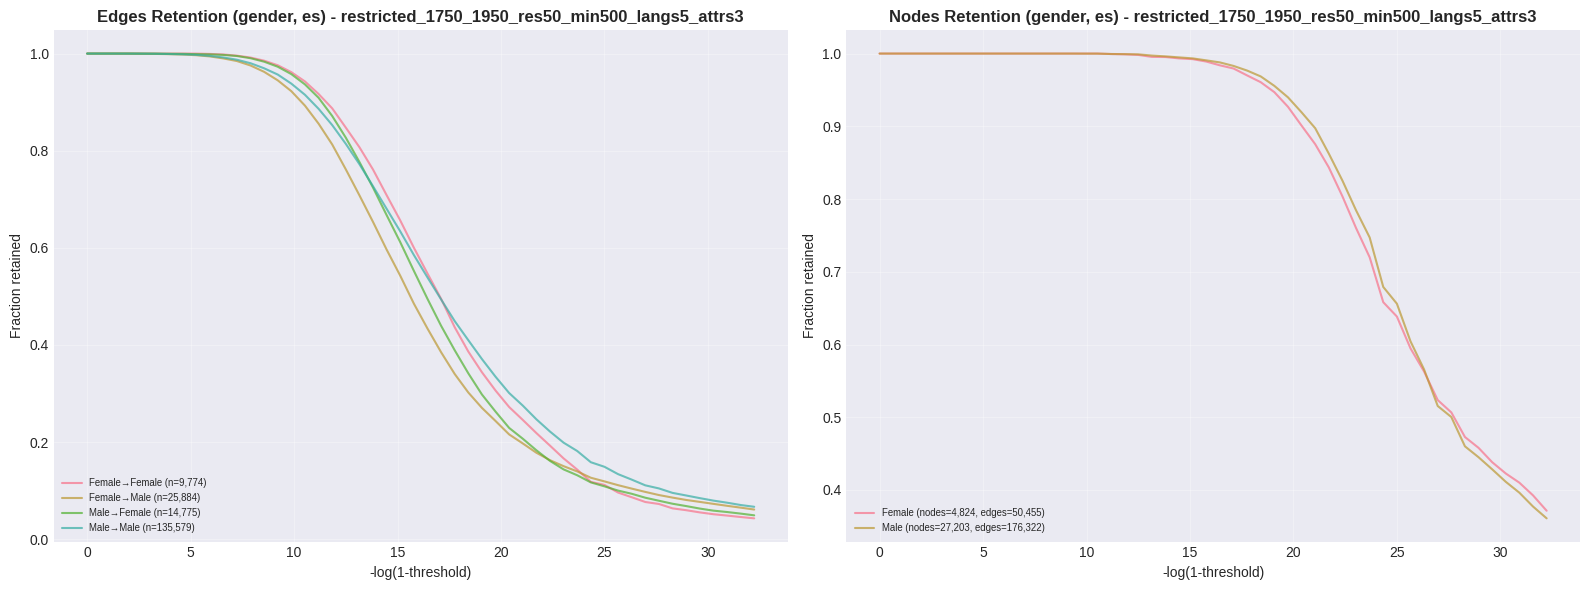

INFO: Saved plot: /home/vlr/Workspaces/WikipediaBiasProject/PyProject/data/out/plots/SpotlightWeightSource_0102_0505_restricted_1750_1950_res50_min500_langs5_attrs3/heatmaps_restricted_1750_1950_res50_min500_langs5_attrs3/heatmap_es_gender.png


  🔥 Plotting AUC heatmap for es - gender...


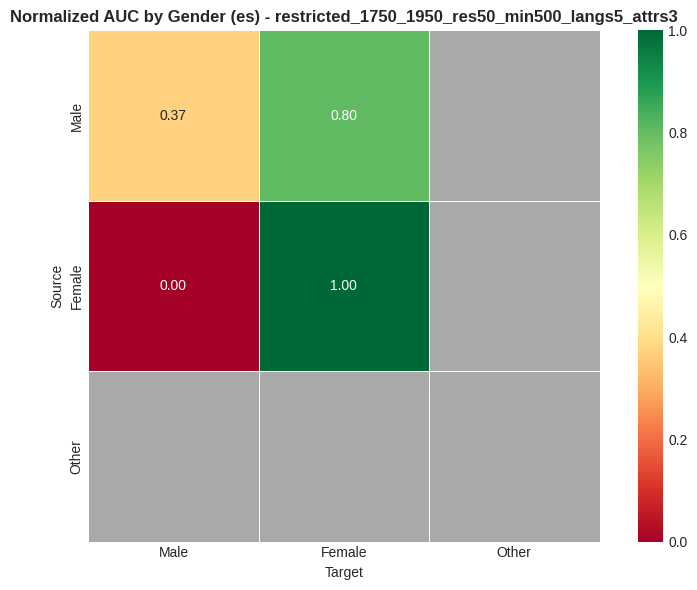


  Attribute: un_subregion
  ----------------------------------------------------------------------------
  📊 Plotting retention curves for es - un_subregion...


INFO: Saved plot: /home/vlr/Workspaces/WikipediaBiasProject/PyProject/data/out/plots/SpotlightWeightSource_0102_0505_restricted_1750_1950_res50_min500_langs5_attrs3/retention_curves_restricted_1750_1950_res50_min500_langs5_attrs3/retention_curves_es_un_subregion.png


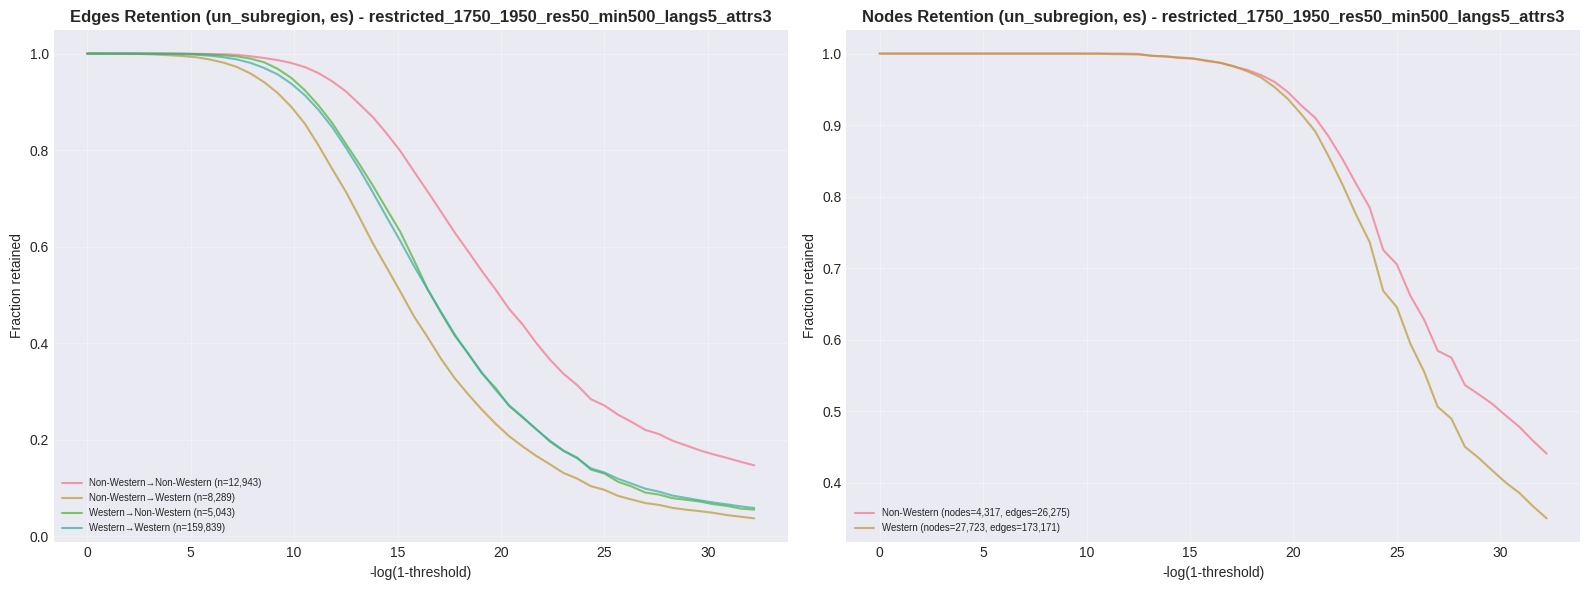

INFO: Saved plot: /home/vlr/Workspaces/WikipediaBiasProject/PyProject/data/out/plots/SpotlightWeightSource_0102_0505_restricted_1750_1950_res50_min500_langs5_attrs3/heatmaps_restricted_1750_1950_res50_min500_langs5_attrs3/heatmap_es_un_subregion.png


  🔥 Plotting AUC heatmap for es - un_subregion...


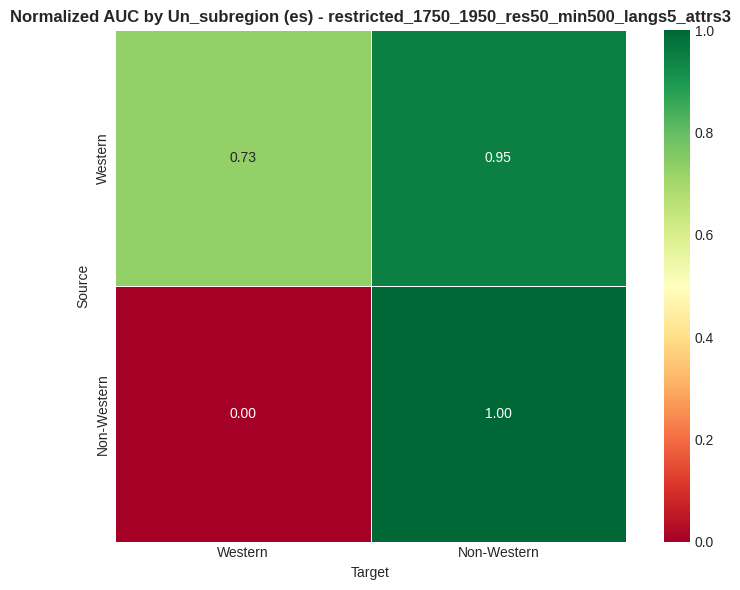


  Attribute: bigperiod_birth
  ----------------------------------------------------------------------------
  📊 Plotting retention curves for es - bigperiod_birth...


INFO: Saved plot: /home/vlr/Workspaces/WikipediaBiasProject/PyProject/data/out/plots/SpotlightWeightSource_0102_0505_restricted_1750_1950_res50_min500_langs5_attrs3/retention_curves_restricted_1750_1950_res50_min500_langs5_attrs3/retention_curves_es_bigperiod_birth.png


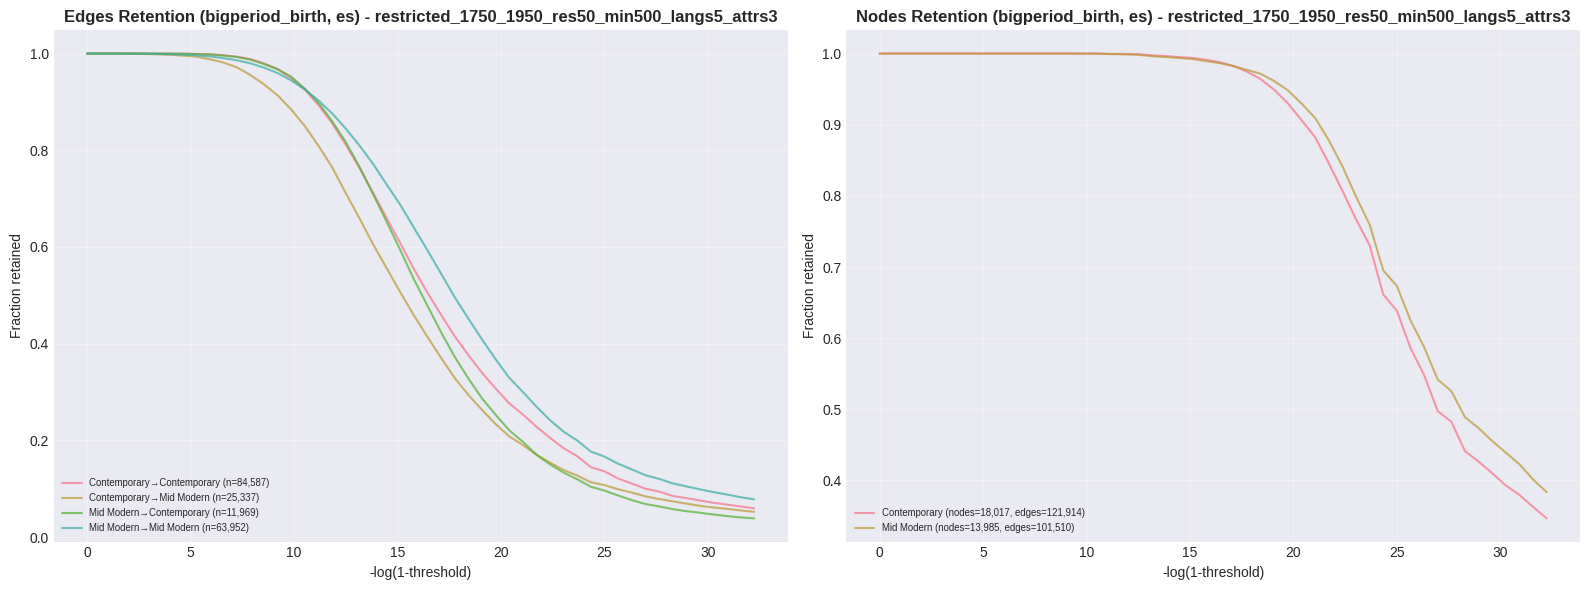

INFO: Saved plot: /home/vlr/Workspaces/WikipediaBiasProject/PyProject/data/out/plots/SpotlightWeightSource_0102_0505_restricted_1750_1950_res50_min500_langs5_attrs3/heatmaps_restricted_1750_1950_res50_min500_langs5_attrs3/heatmap_es_bigperiod_birth.png


  🔥 Plotting AUC heatmap for es - bigperiod_birth...


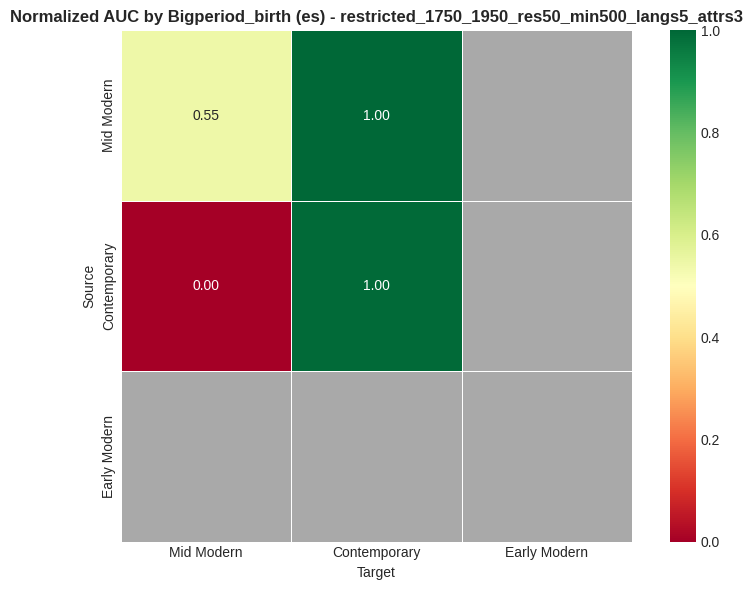


Language: ALL

  Attribute: gender
  ----------------------------------------------------------------------------
  📊 Plotting retention curves for all - gender...


INFO: Saved plot: /home/vlr/Workspaces/WikipediaBiasProject/PyProject/data/out/plots/SpotlightWeightSource_0102_0505_restricted_1750_1950_res50_min500_langs5_attrs3/retention_curves_restricted_1750_1950_res50_min500_langs5_attrs3/retention_curves_all_gender.png


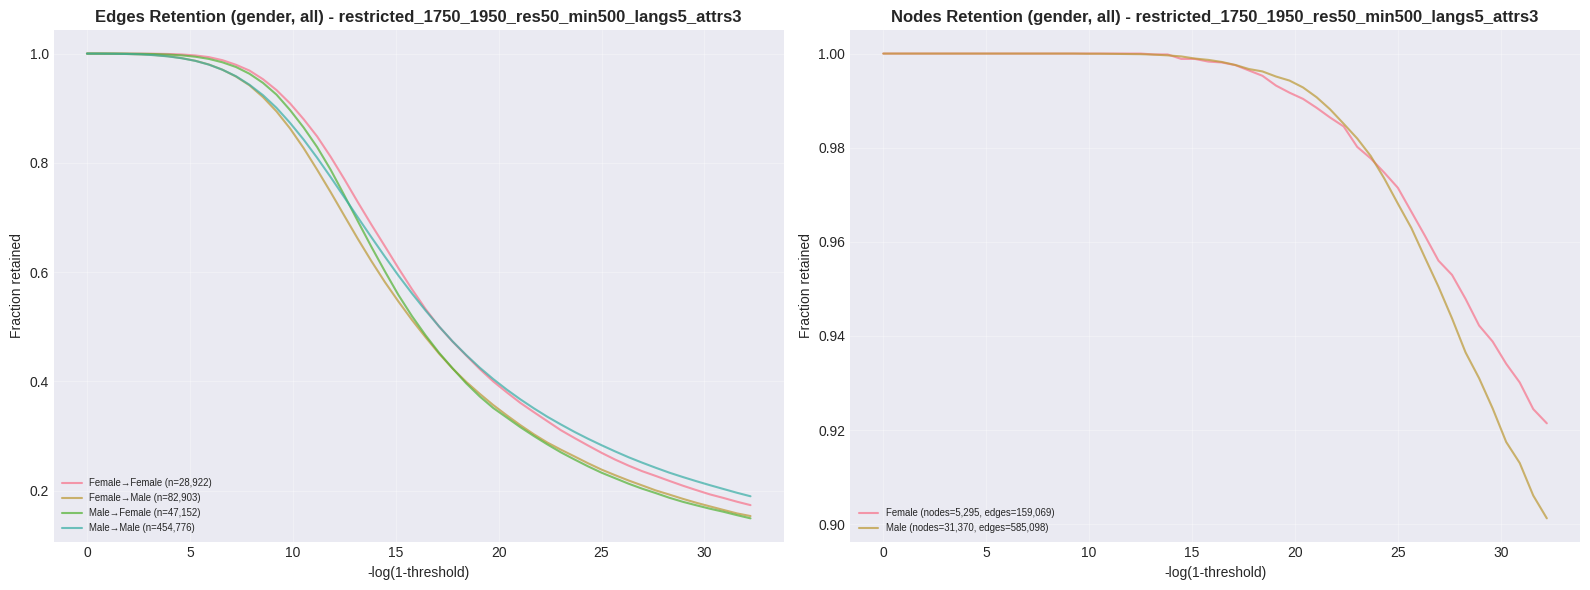

INFO: Saved plot: /home/vlr/Workspaces/WikipediaBiasProject/PyProject/data/out/plots/SpotlightWeightSource_0102_0505_restricted_1750_1950_res50_min500_langs5_attrs3/heatmaps_restricted_1750_1950_res50_min500_langs5_attrs3/heatmap_all_gender.png


  🔥 Plotting AUC heatmap for all - gender...


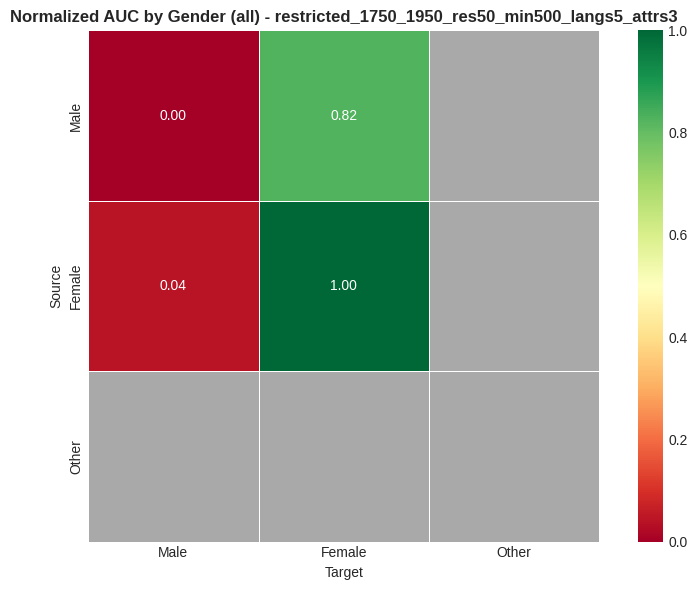


  Attribute: un_subregion
  ----------------------------------------------------------------------------
  📊 Plotting retention curves for all - un_subregion...


INFO: Saved plot: /home/vlr/Workspaces/WikipediaBiasProject/PyProject/data/out/plots/SpotlightWeightSource_0102_0505_restricted_1750_1950_res50_min500_langs5_attrs3/retention_curves_restricted_1750_1950_res50_min500_langs5_attrs3/retention_curves_all_un_subregion.png


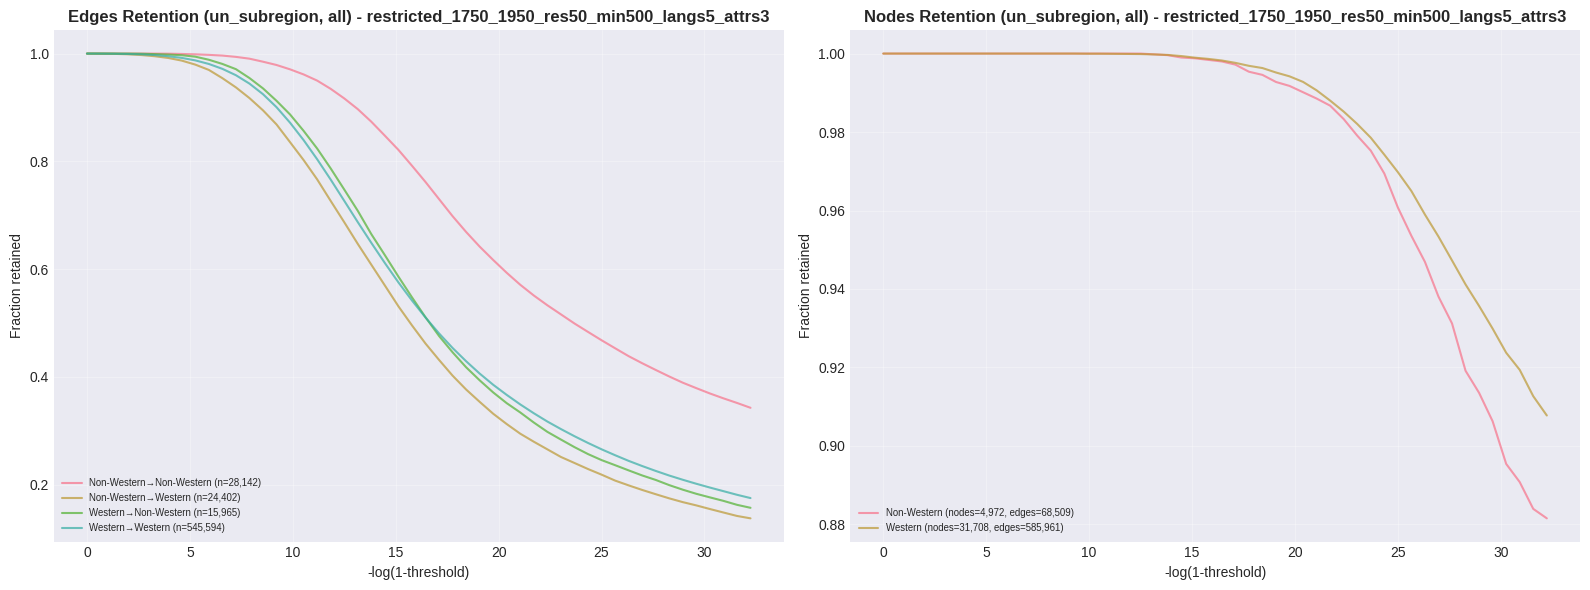

INFO: Saved plot: /home/vlr/Workspaces/WikipediaBiasProject/PyProject/data/out/plots/SpotlightWeightSource_0102_0505_restricted_1750_1950_res50_min500_langs5_attrs3/heatmaps_restricted_1750_1950_res50_min500_langs5_attrs3/heatmap_all_un_subregion.png


  🔥 Plotting AUC heatmap for all - un_subregion...


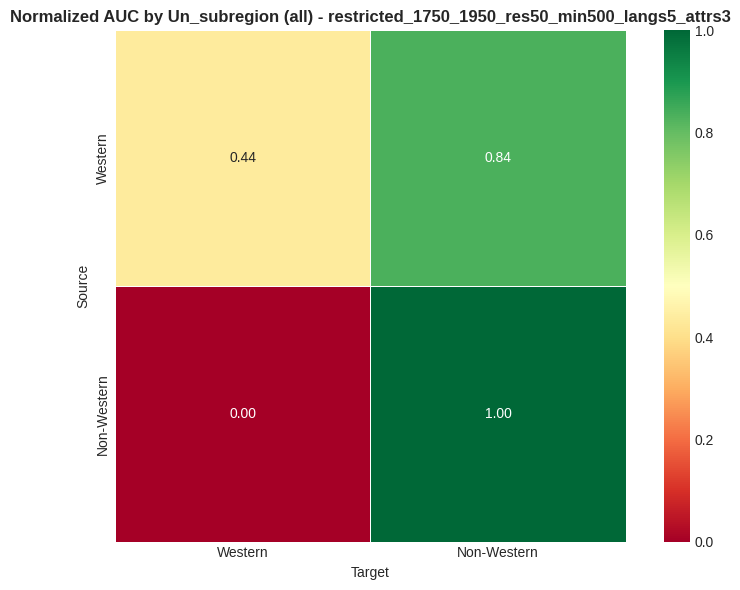


  Attribute: bigperiod_birth
  ----------------------------------------------------------------------------
  📊 Plotting retention curves for all - bigperiod_birth...


INFO: Saved plot: /home/vlr/Workspaces/WikipediaBiasProject/PyProject/data/out/plots/SpotlightWeightSource_0102_0505_restricted_1750_1950_res50_min500_langs5_attrs3/retention_curves_restricted_1750_1950_res50_min500_langs5_attrs3/retention_curves_all_bigperiod_birth.png


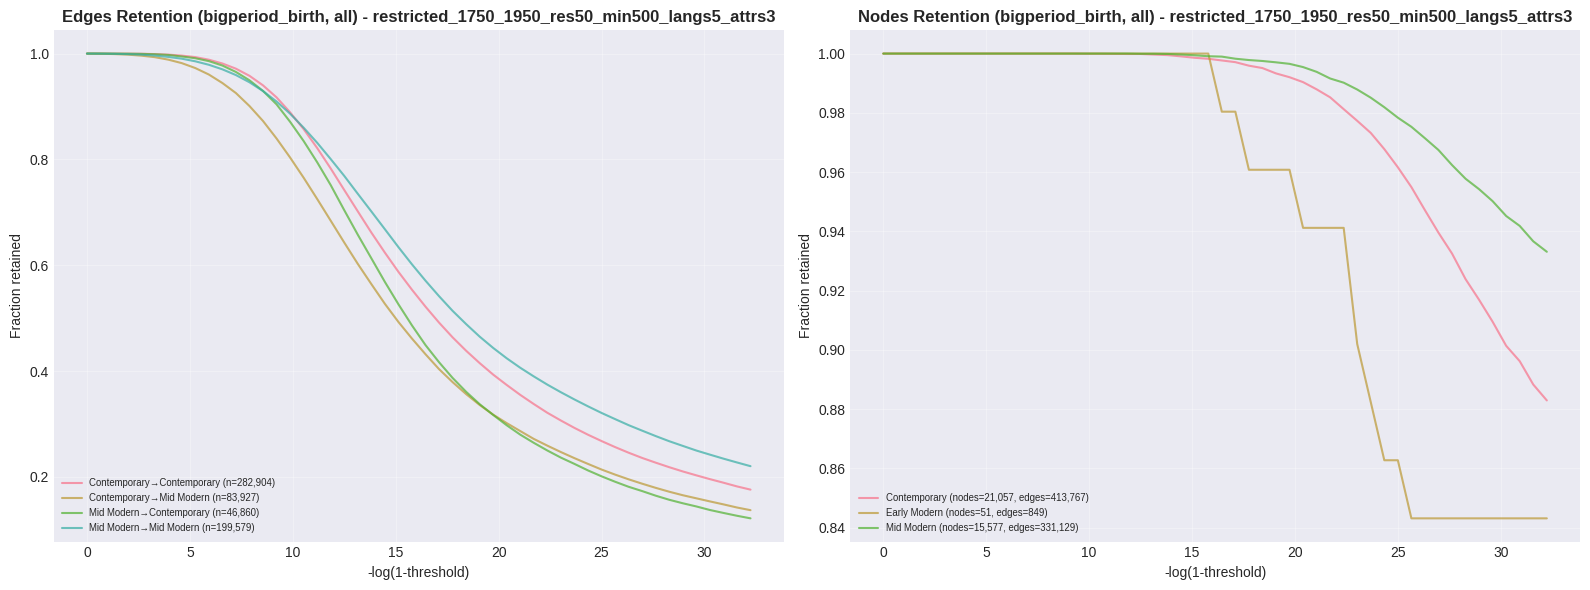

INFO: Saved plot: /home/vlr/Workspaces/WikipediaBiasProject/PyProject/data/out/plots/SpotlightWeightSource_0102_0505_restricted_1750_1950_res50_min500_langs5_attrs3/heatmaps_restricted_1750_1950_res50_min500_langs5_attrs3/heatmap_all_bigperiod_birth.png


  🔥 Plotting AUC heatmap for all - bigperiod_birth...


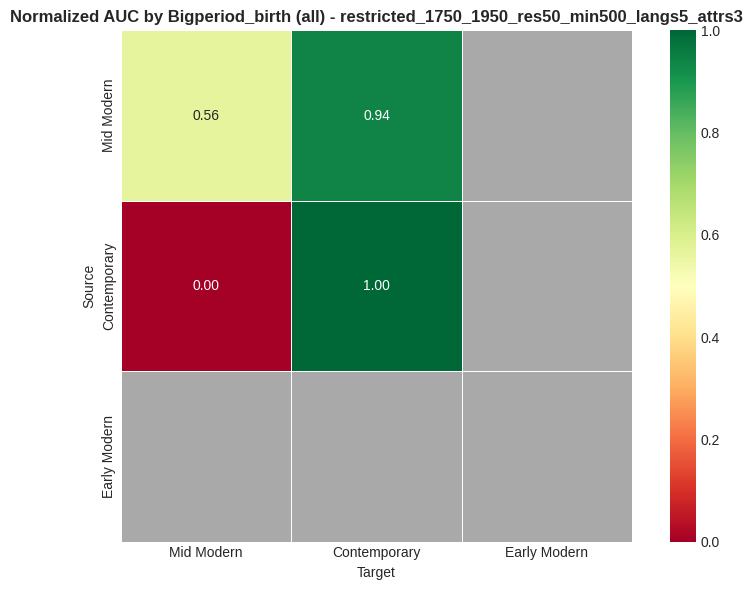


✓ TIME-RESTRICTED DATASET: Generated 36 total plots
✓ All plots saved to: /home/vlr/Workspaces/WikipediaBiasProject/PyProject/data/out/plots/SpotlightWeightSource_0102_0505_restricted_1750_1950_res50_min500_langs5_attrs3


In [7]:
print("="*80)
print(f"GENERATING ALL PLOTS FOR TIME-RESTRICTED DATASET ({MIN_YEAR}-{MAX_YEAR})")
print("="*80)
print(f"Total plots to generate: {len(ALL_LANGUAGES_WITH_AGG) * len(ATTRIBUTES) * 2}")
print()

plot_count = 0

# Generate plots for each language
for lang in ALL_LANGUAGES_WITH_AGG:
    print(f"\n{'='*80}")
    print(f"Language: {lang.upper()}")
    print(f"{'='*80}")
    
    # Generate plots for each attribute
    for attr in ATTRIBUTES:
        print(f"\n  Attribute: {attr}")
        print(f"  {'-'*76}")
        
        # Plot retention curves
        print(f"  📊 Plotting retention curves for {lang} - {attr}...")
        analysis.plot_retention_results(
            retention_restricted,
            languages=[lang],
            attributes=[attr],
            min_edges=MIN_EDGES,
            plot_type='curves',
            figsize=(16, 6),
            save_dir=OUTPUT_DIRS_RESTRICTED['base']
        )
        plot_count += 1
        
        # Plot AUC heatmap
        print(f"  🔥 Plotting AUC heatmap for {lang} - {attr}...")
        analysis.plot_retention_results(
            retention_restricted,
            languages=[lang],
            attributes=[attr],
            min_edges=MIN_EDGES,
            plot_type='heatmaps',
            figsize=(10, 8),
            save_dir=OUTPUT_DIRS_RESTRICTED['base']
        )
        plot_count += 1

print(f"\n{'='*80}")
print(f"✓ TIME-RESTRICTED DATASET: Generated {plot_count} total plots")
print(f"✓ All plots saved to: {OUTPUT_DIRS_RESTRICTED['base']}")
print(f"{'='*80}")

---
# Summary

## Complete Analysis Report

In [8]:
print("\n" + "="*80)
print("COMPREHENSIVE BIAS ANALYSIS - COMPLETE")
print("="*80)
print()
print("📊 ANALYSIS COVERAGE:")
print(f"  • Languages analyzed: {len(ALL_LANGUAGES_WITH_AGG)} ({', '.join(ALL_LANGUAGES_WITH_AGG)})")
print(f"  • Attributes analyzed: {len(ATTRIBUTES)} ({', '.join(ATTRIBUTES)})")
print(f"  • Datasets analyzed: 2 (full + time-restricted)")
print()
print("📈 PLOTS GENERATED:")
print(f"  • Per dataset: {len(ALL_LANGUAGES_WITH_AGG)} langs × {len(ATTRIBUTES)} attrs × 2 types = {len(ALL_LANGUAGES_WITH_AGG) * len(ATTRIBUTES) * 2} plots")
print(f"  • Total across both datasets: {len(ALL_LANGUAGES_WITH_AGG) * len(ATTRIBUTES) * 2 * 2} plots")
print()
print("💾 OUTPUT LOCATIONS:")
print(f"  • Full dataset plots:")
print(f"    - {OUTPUT_DIRS_FULL['base']}/retention_curves_full/")
print(f"    - {OUTPUT_DIRS_FULL['base']}/heatmaps_full/")
print(f"  • Time-restricted dataset plots:")
print(f"    - {OUTPUT_DIRS_RESTRICTED['base']}/retention_curves_restricted_{MIN_YEAR}_{MAX_YEAR}/")
print(f"    - {OUTPUT_DIRS_RESTRICTED['base']}/heatmaps_restricted_{MIN_YEAR}_{MAX_YEAR}/")
print()
print("📁 DATA FILES:")
print(f"  • AUC matrices: {OUTPUT_DIRS_FULL['auc']}/ (and restricted equivalent)")
print(f"  • Retention data: {OUTPUT_DIRS_FULL['retention_data']}/ (and restricted equivalent)")
print()
print("✓ All visualizations and data successfully generated!")
print("="*80)


COMPREHENSIVE BIAS ANALYSIS - COMPLETE

📊 ANALYSIS COVERAGE:
  • Languages analyzed: 6 (en, de, fr, it, es, all)
  • Attributes analyzed: 3 (gender, un_subregion, bigperiod_birth)
  • Datasets analyzed: 2 (full + time-restricted)

📈 PLOTS GENERATED:
  • Per dataset: 6 langs × 3 attrs × 2 types = 36 plots
  • Total across both datasets: 72 plots

💾 OUTPUT LOCATIONS:
  • Full dataset plots:
    - /home/vlr/Workspaces/WikipediaBiasProject/PyProject/data/out/plots/SpotlightWeightSource_0102_0505_full_res50_min500_langs5_attrs3/retention_curves_full/
    - /home/vlr/Workspaces/WikipediaBiasProject/PyProject/data/out/plots/SpotlightWeightSource_0102_0505_full_res50_min500_langs5_attrs3/heatmaps_full/
  • Time-restricted dataset plots:
    - /home/vlr/Workspaces/WikipediaBiasProject/PyProject/data/out/plots/SpotlightWeightSource_0102_0505_restricted_1750_1950_res50_min500_langs5_attrs3/retention_curves_restricted_1750_1950/
    - /home/vlr/Workspaces/WikipediaBiasProject/PyProject/data/out/p

## Next Steps

Now that you have generated all plots, you can:

1. **Review the plots** saved in the output directories
2. **Compare patterns** across languages and attributes
3. **Analyze the AUC matrices** for quantitative bias measurements
4. **Study retention curves** to understand how bias manifests at different threshold levels
5. **Compare full vs. time-restricted** datasets to see temporal effects

### Plot Types Explained

**Retention Curves:**
- Left panel: Edge retention showing link survival rates between attribute groups
- Right panel: Node retention showing entity visibility at different thresholds

**AUC Heatmaps:**
- Shows normalized Area Under Curve values for all source→target attribute pairs
- Values closer to 1 (green) indicate better retention
- Values closer to 0 (red) indicate worse retention
- Diagonal cells show within-group retention
- Off-diagonal cells show cross-group retention patterns